In [1]:
import matplotlib.pyplot as plt
import numpy as np

import time

import os

os.environ['CUDA_VISIBLE_DEVICES']="1"

from keras.layers import Dense, Input
from keras.models import Model

import omnifold6 as of
import os
import tensorflow as tf


In [2]:
print("\n\n")
print("  numpy version:  %s" % str(np.version.version) )
print("  tensorflow version:  %s" % str(tf.__version__))
print("\n\n")




  numpy version:  1.21.5
  tensorflow version:  2.11.0





## Set model and resolution parameters

In [3]:
train_mu0 = 0.
train_mu1 = 1.
train_rho01 = -0.6

train_sig0 = 1.0
train_sig1 = 1.5

train_cov00 = train_sig0 * train_sig0 
train_cov11 = train_sig1 * train_sig1
train_cov01 = train_rho01 * train_sig0 * train_sig1

train_cov = np.array( [[train_cov00, train_cov01], [train_cov01, train_cov11]] )
train_mu = np.array( [train_mu0, train_mu1])



true_mu0 = 0.2
true_mu1 = 0.8
true_rho01 = -0.6

true_sig0 = 0.9
true_sig1 = 1.3

true_cov00 = true_sig0 * true_sig0 
true_cov11 = true_sig1 * true_sig1
true_cov01 = true_rho01 * true_sig0 * true_sig1

true_cov = np.array( [[true_cov00, true_cov01], [true_cov01, true_cov11]] )
true_mu = np.array( [true_mu0, true_mu1])



#--- resolution is in same dimensions as features (not sigma/val)

#-- nominal resolution
#res0 = 0.5
#res1 = 0.8


#-- near perfect resolution
res0 = 0.001
res1 = 0.001


#-- poor resolution
#res0 = 1.0
#res1 = 1.6




ngen_train = 100000
ngen_true =   10000

#ngen_train = 1000000
#ngen_true =   100000

#ngen_train = 1000000
#ngen_true =    10000



of_niter = 6

learning_rate_setval = 0.0005

epochs_setval = 20

batch_size_setval = int( ngen_true )



n_boot_samples = 250

do_bootstrap = True


output_filebase = 'bootstrap-output-test6'


## Plots to visualize these parameter choices

In [4]:



train_pts = np.random.multivariate_normal(train_mu, train_cov, size=ngen_train)
true_pts = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true)

train_det_pts = np.random.normal( train_pts, [res0, res1])

true_det_pts = np.random.normal( true_pts, [res0, res1])



<function matplotlib.pyplot.show(close=None, block=None)>

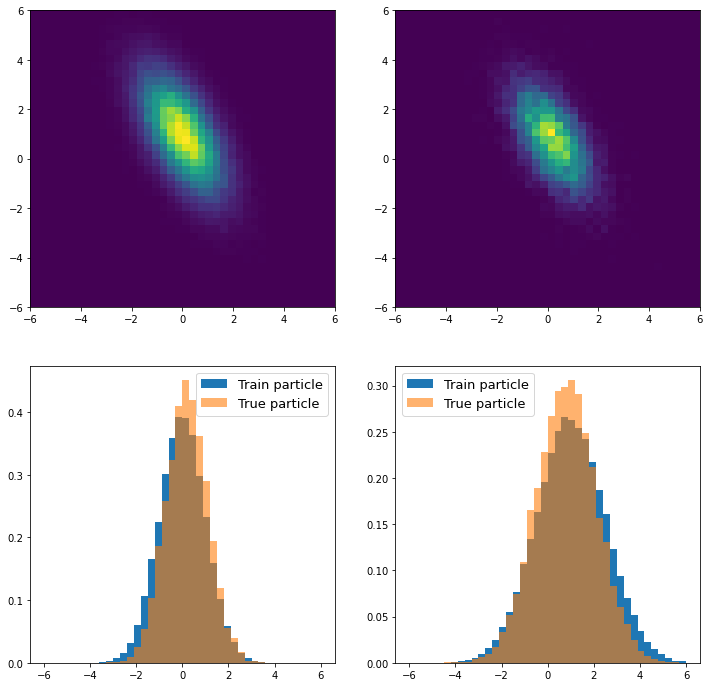

In [5]:
fig,ax = plt.subplots( 2, 2, figsize=(12,12))

hmin=-6
hmax=6
hbins=40

ax[0][0].hist2d( train_pts[:,0], train_pts[:,1], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))

ax[0][1].hist2d( true_pts[:,0], true_pts[:,1], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))

ax[1][0].hist( train_pts[:,0], bins=hbins, range=[hmin,hmax], density=True, label='Train particle' )
ax[1][0].hist( true_pts[:,0], bins=hbins, range=[hmin,hmax], density=True, label='True particle', alpha=0.6)

ax[1][1].hist( train_pts[:,1], bins=hbins, range=[hmin,hmax], density=True, label='Train particle' )
ax[1][1].hist( true_pts[:,1], bins=hbins, range=[hmin,hmax], density=True, label='True particle', alpha=0.6)


ax[1][0].legend(loc='best', fontsize=13)
ax[1][1].legend(loc='best', fontsize=13)

plt.show

In [6]:
train_diff = train_det_pts - train_pts

In [7]:
diff_cov = np.cov( train_diff.T )

In [8]:
diff_cov

array([[1.00339773e-06, 3.83420257e-10],
       [3.83420257e-10, 9.97383500e-07]])

In [9]:
np.sqrt(diff_cov[0,0])

0.0010016974245024802

In [10]:
np.sqrt(diff_cov[1,1])

0.00099869089320671

<function matplotlib.pyplot.show(close=None, block=None)>

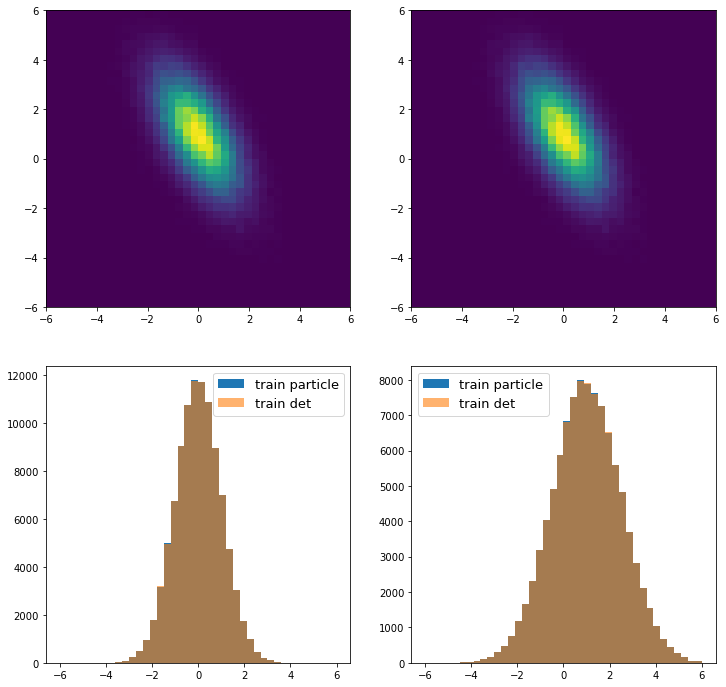

In [11]:
fig,ax = plt.subplots( 2, 2, figsize=(12,12))

hmin=-6
hmax=6
hbins=40

ax[0][0].hist2d( train_pts[:,0], train_pts[:,1], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))

ax[0][1].hist2d( train_det_pts[:,0], train_det_pts[:,1], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))

ax[1][0].hist( train_pts[:,0], bins=hbins, range=[hmin,hmax], label='train particle' )
ax[1][0].hist( train_det_pts[:,0], bins=hbins, range=[hmin,hmax], label='train det', alpha=0.6)

ax[1][1].hist( train_pts[:,1], bins=hbins, range=[hmin,hmax], label='train particle' )
ax[1][1].hist( train_det_pts[:,1], bins=hbins, range=[hmin,hmax], label='train det', alpha=0.6)


ax[1][0].legend(loc='best', fontsize=13)
ax[1][1].legend(loc='best', fontsize=13)

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

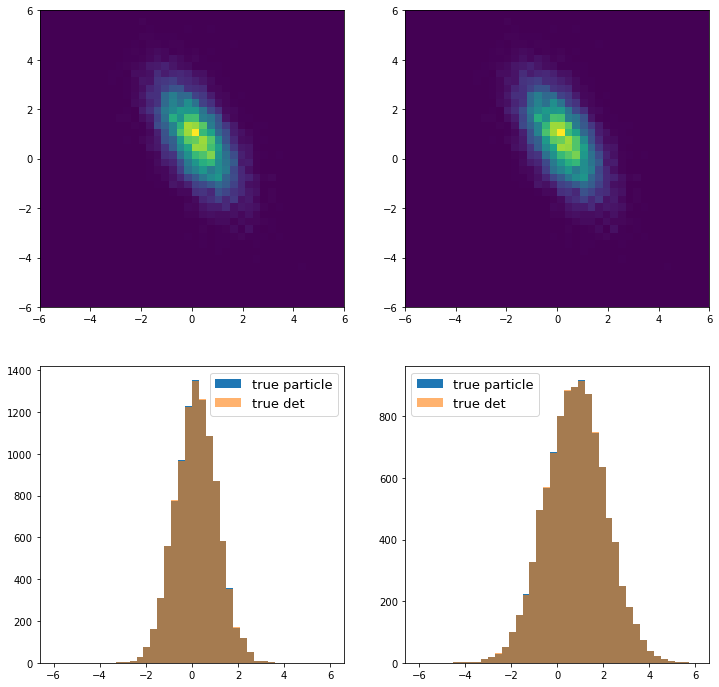

In [12]:
fig,ax = plt.subplots( 2, 2, figsize=(12,12))

hmin=-6
hmax=6
hbins=40

ax[0][0].hist2d( true_pts[:,0], true_pts[:,1], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))

ax[0][1].hist2d( true_det_pts[:,0], true_det_pts[:,1], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))

ax[1][0].hist( true_pts[:,0], bins=hbins, range=[hmin,hmax], label='true particle' )
ax[1][0].hist( true_det_pts[:,0], bins=hbins, range=[hmin,hmax], label='true det', alpha=0.6)

ax[1][1].hist( true_pts[:,1], bins=hbins, range=[hmin,hmax], label='true particle' )
ax[1][1].hist( true_det_pts[:,1], bins=hbins, range=[hmin,hmax], label='true det', alpha=0.6)


ax[1][0].legend(loc='best', fontsize=13)
ax[1][1].legend(loc='best', fontsize=13)

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

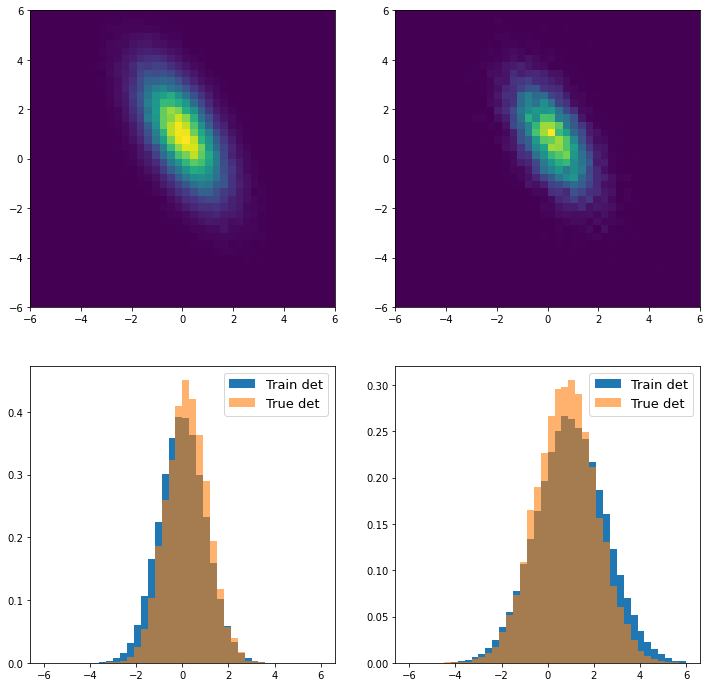

In [13]:
fig,ax = plt.subplots( 2, 2, figsize=(12,12))

hmin=-6
hmax=6
hbins=40

ax[0][0].hist2d( train_det_pts[:,0], train_det_pts[:,1], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))

ax[0][1].hist2d( true_det_pts[:,0], true_det_pts[:,1], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))

ax[1][0].hist( train_det_pts[:,0], bins=hbins, density=True, range=[hmin,hmax], label='Train det' )
ax[1][0].hist( true_det_pts[:,0], bins=hbins, density=True, range=[hmin,hmax], label='True det', alpha=0.6)

ax[1][1].hist( train_det_pts[:,1], bins=hbins, density=True, range=[hmin,hmax], label='Train det' )
ax[1][1].hist( true_det_pts[:,1], bins=hbins, density=True, range=[hmin,hmax], label='True det', alpha=0.6)


ax[1][0].legend(loc='best', fontsize=13)
ax[1][1].legend(loc='best', fontsize=13)

plt.show

## Set up NN model for OmniFold

In [14]:
inputs = Input((2, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)
model = Model(inputs=inputs, outputs=outputs)

2023-12-03 17:45:08.549004: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-03 17:45:08.566289: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-03 17:45:08.566529: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-03 17:45:08.569820: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-03 17:45:08.570007: I tensorflow/compiler/xla/stream_executo

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 50)                150       
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 50)                2550      
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 5,301
Trainable params: 5,301
Non-trainable params: 0
_________________________________________________________________


## Package the training data for OmniFold

In [16]:
train_both = np.stack([train_pts, train_det_pts], axis=1)

## Run OmniFold

In [17]:
%%time


verbose = True



of_return_dict = of.omnifold6( 
    train_both, true_det_pts, of_niter, model, verbose, 
    batch_size_setval, learning_rate_setval, epochs_setval )

of_weights = of_return_dict["weights"]

mc_weight_sf = (1.*len(true_det_pts))/(1.*len(train_both))

push_weights = of_return_dict["push_weights"]
push_weights_scaled = np.copy( push_weights )
push_weights_scaled = mc_weight_sf * push_weights

final_push_weights = of_return_dict["final_push_weights"]
final_push_weights_scaled = np.copy(final_push_weights)
final_push_weights_scaled = mc_weight_sf * final_push_weights








  ======== omnifold6


  shape of theta0_S : (100000, 2)
  shape of theta_unknown_S : (10000, 2)
  shape of xvals_1 :  (110000, 2)



  shape of labels0 : (100000,)
  shape of labels_unknown : (10000,)
  shape of yvals_1 :  (110000,)



  shape of theta0_G : (100000, 2)
  shape of xvals_2 :  (200000, 2)
  shape of yvals_2 :  (200000,)

 batch size setval  10000
 learning rate setval  0.000500
 epochs setval  20




ITERATION: 1

   -- ITERATION 1  STEP 1

 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
             running pre-training, distinguish from self.
Epoch 1/5


2023-12-03 17:45:10.304779: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-12-03 17:45:10.306507: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fa8398f8470 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-03 17:45:10.306519: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-12-03 17:45:10.310078: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-03 17:45:10.393983: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


15/15 [==============================] - 2s 3ms/step - loss: 0.6933 - accuracy: 0.5447
Epoch 2/5
15/15 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.4344
Epoch 3/5
15/15 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.6138
Epoch 4/5
15/15 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5698
Epoch 5/5
15/15 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.4806
             done pretraining.
Epoch 1/40
9/9 [==============================] - 0s 17ms/step - loss: 0.1258 - accuracy: 0.3510 - val_loss: 0.1260 - val_accuracy: 0.3900
Epoch 2/40
9/9 [==============================] - 0s 5ms/step - loss: 0.1253 - accuracy: 0.3830 - val_loss: 0.1257 - val_accuracy: 0.3693
Epoch 3/40
9/9 [==============================] - 0s 4ms/step - loss: 0.1250 - accuracy: 0.3610 - val_loss: 0.1254 - val_accuracy: 0.3488
Epoch 4/40
9/9 [==============================] - 0s 4ms/step - loss: 0.1248 - 

15/15 [==============================] - 0s 3ms/step - loss: 0.6805 - accuracy: 0.3911 - val_loss: 0.6802 - val_accuracy: 0.3910
Epoch 12/40
15/15 [==============================] - 0s 3ms/step - loss: 0.6804 - accuracy: 0.3907 - val_loss: 0.6802 - val_accuracy: 0.3906
Epoch 13/40
15/15 [==============================] - 0s 3ms/step - loss: 0.6804 - accuracy: 0.3903 - val_loss: 0.6802 - val_accuracy: 0.3902
Epoch 14/40
15/15 [==============================] - 0s 3ms/step - loss: 0.6804 - accuracy: 0.3900 - val_loss: 0.6802 - val_accuracy: 0.3899
Epoch 15/40
15/15 [==============================] - 0s 3ms/step - loss: 0.6804 - accuracy: 0.3897 - val_loss: 0.6802 - val_accuracy: 0.3898
Epoch 16/40
15/15 [==============================] - 0s 4ms/step - loss: 0.6804 - accuracy: 0.3896 - val_loss: 0.6802 - val_accuracy: 0.3896
Epoch 17/40
15/15 [==============================] - 0s 3ms/step - loss: 0.6804 - accuracy: 0.3895 - val_loss: 0.6802 - val_accuracy: 0.3895
Epoch 18/40
15/15 [======

Epoch 4/5
15/15 [==============================] - 0s 2ms/step - loss: 0.6933 - accuracy: 0.5792
Epoch 5/5
15/15 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5776
             done pretraining.
Epoch 1/20
15/15 [==============================] - 0s 10ms/step - loss: 0.6921 - accuracy: 0.2505 - val_loss: 0.6927 - val_accuracy: 0.2484
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 0.6921 - accuracy: 0.2507 - val_loss: 0.6927 - val_accuracy: 0.2481
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 0.6921 - accuracy: 0.2506 - val_loss: 0.6927 - val_accuracy: 0.2484
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 0.6921 - accuracy: 0.2506 - val_loss: 0.6927 - val_accuracy: 0.2482
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 0.6921 - accuracy: 0.2506 - val_loss: 0.6927 - val_accuracy: 0.2480
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 0.

Epoch 8/20
15/15 [==============================] - 0s 3ms/step - loss: 0.6988 - accuracy: 0.2503 - val_loss: 0.6980 - val_accuracy: 0.2490
Epoch 9/20
15/15 [==============================] - 0s 3ms/step - loss: 0.6988 - accuracy: 0.2503 - val_loss: 0.6980 - val_accuracy: 0.2490
Epoch 10/20
15/15 [==============================] - 0s 3ms/step - loss: 0.6988 - accuracy: 0.2503 - val_loss: 0.6980 - val_accuracy: 0.2490
Epoch 11/20
15/15 [==============================] - 0s 3ms/step - loss: 0.6988 - accuracy: 0.2503 - val_loss: 0.6980 - val_accuracy: 0.2488
Epoch 12/20
15/15 [==============================] - 0s 3ms/step - loss: 0.6988 - accuracy: 0.2504 - val_loss: 0.6980 - val_accuracy: 0.2487
Epoch 13/20
15/15 [==============================] - 0s 3ms/step - loss: 0.6988 - accuracy: 0.2504 - val_loss: 0.6980 - val_accuracy: 0.2488
Epoch 14/20
15/15 [==============================] - 0s 3ms/step - loss: 0.6988 - accuracy: 0.2505 - val_loss: 0.6980 - val_accuracy: 0.2488
Epoch 15/20
15/

15/15 [==============================] - 0s 3ms/step - loss: 0.6939 - accuracy: 0.2504 - val_loss: 0.6943 - val_accuracy: 0.2486
Epoch 17/20
15/15 [==============================] - 0s 3ms/step - loss: 0.6939 - accuracy: 0.2505 - val_loss: 0.6943 - val_accuracy: 0.2484
Epoch 18/20
15/15 [==============================] - 0s 3ms/step - loss: 0.6939 - accuracy: 0.2505 - val_loss: 0.6943 - val_accuracy: 0.2485
Epoch 19/20
15/15 [==============================] - 0s 3ms/step - loss: 0.6939 - accuracy: 0.2505 - val_loss: 0.6943 - val_accuracy: 0.2486
Epoch 20/20
10/10 [==============================] - 0s 681us/step

ITERATION: 5

   -- ITERATION 5  STEP 1

 weights_push at the beginning
[0.52514305 0.88585752 1.24429077 ... 1.09924617 1.36688838 1.3086138 ]
             running pre-training, distinguish from self.
Epoch 1/5
15/15 [==============================] - 1s 2ms/step - loss: 0.6933 - accuracy: 0.5011
Epoch 2/5
15/15 [==============================] - 0s 2ms/step - loss: 0.6932 - a

15/15 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5837
Epoch 4/5
15/15 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.4634
Epoch 5/5
15/15 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5999
             done pretraining.
Epoch 1/20
9/9 [==============================] - 0s 14ms/step - loss: 0.1265 - accuracy: 0.3236 - val_loss: 0.1257 - val_accuracy: 0.2832
Epoch 2/20
9/9 [==============================] - 0s 5ms/step - loss: 0.1265 - accuracy: 0.2641 - val_loss: 0.1258 - val_accuracy: 0.2704
Epoch 3/20
9/9 [==============================] - 0s 4ms/step - loss: 0.1265 - accuracy: 0.3099 - val_loss: 0.1257 - val_accuracy: 0.3283
Epoch 4/20
9/9 [==============================] - 0s 5ms/step - loss: 0.1265 - accuracy: 0.3089 - val_loss: 0.1258 - val_accuracy: 0.2894
Epoch 5/20
9/9 [==============================] - 0s 4ms/step - loss: 0.1265 - accuracy: 0.2838 - val_loss: 0.1258 - val_accuracy: 0.27

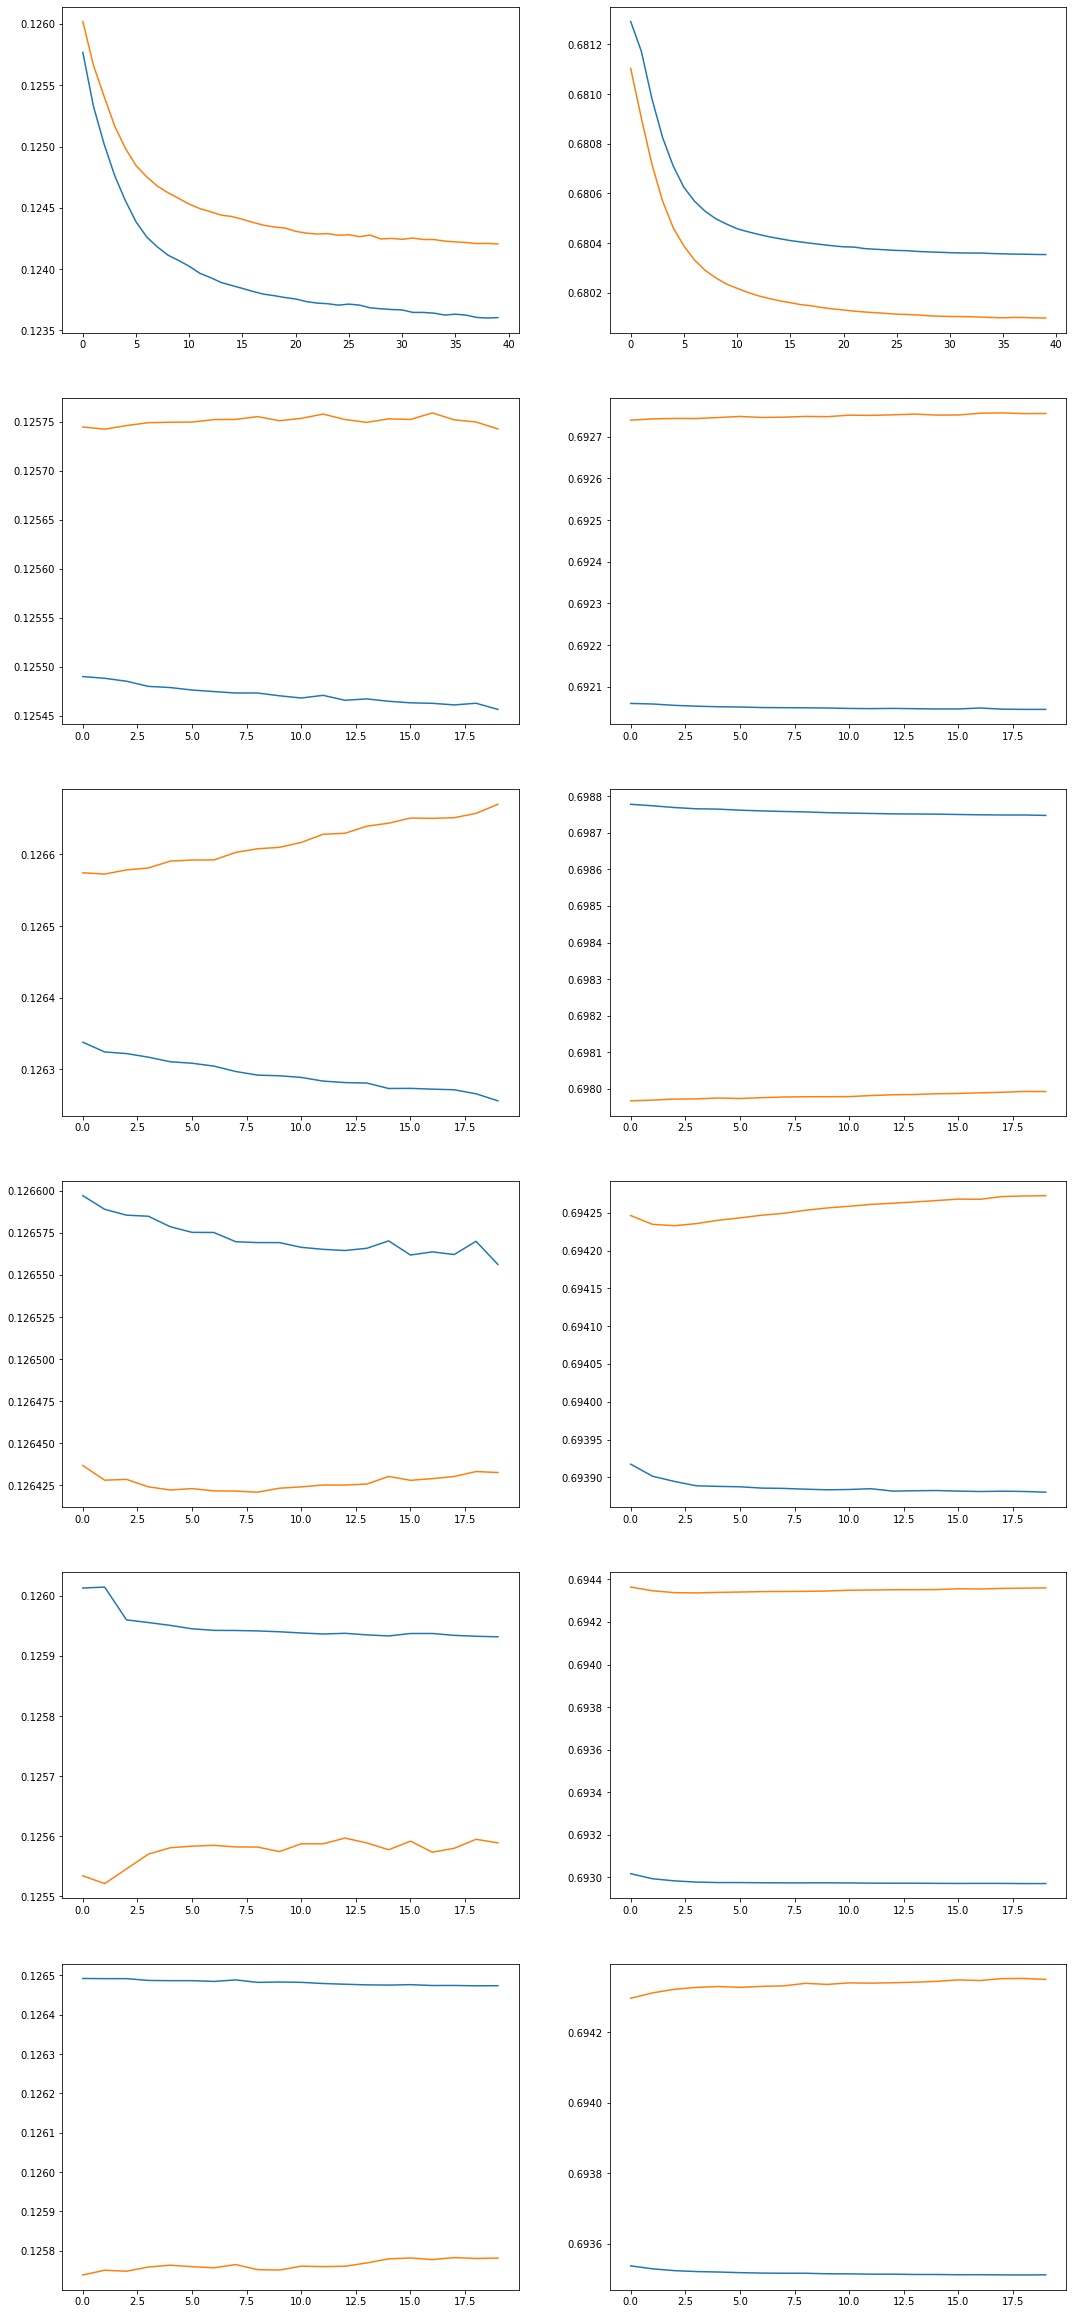

In [18]:
fig,ax = plt.subplots( of_niter, 2, figsize=(18,7*of_niter))

for ofi in range(0,of_niter) :
    
    ax[ofi][0].plot( of_return_dict['train-hist-step1-iter%d' % ofi].history['loss']  )
    ax[ofi][0].plot( of_return_dict['train-hist-step1-iter%d' % ofi].history['val_loss']  )

    ax[ofi][1].plot( of_return_dict['train-hist-step2-iter%d' % ofi].history['loss']  )
    ax[ofi][1].plot( of_return_dict['train-hist-step2-iter%d' % ofi].history['val_loss']  )
    



<function matplotlib.pyplot.show(close=None, block=None)>

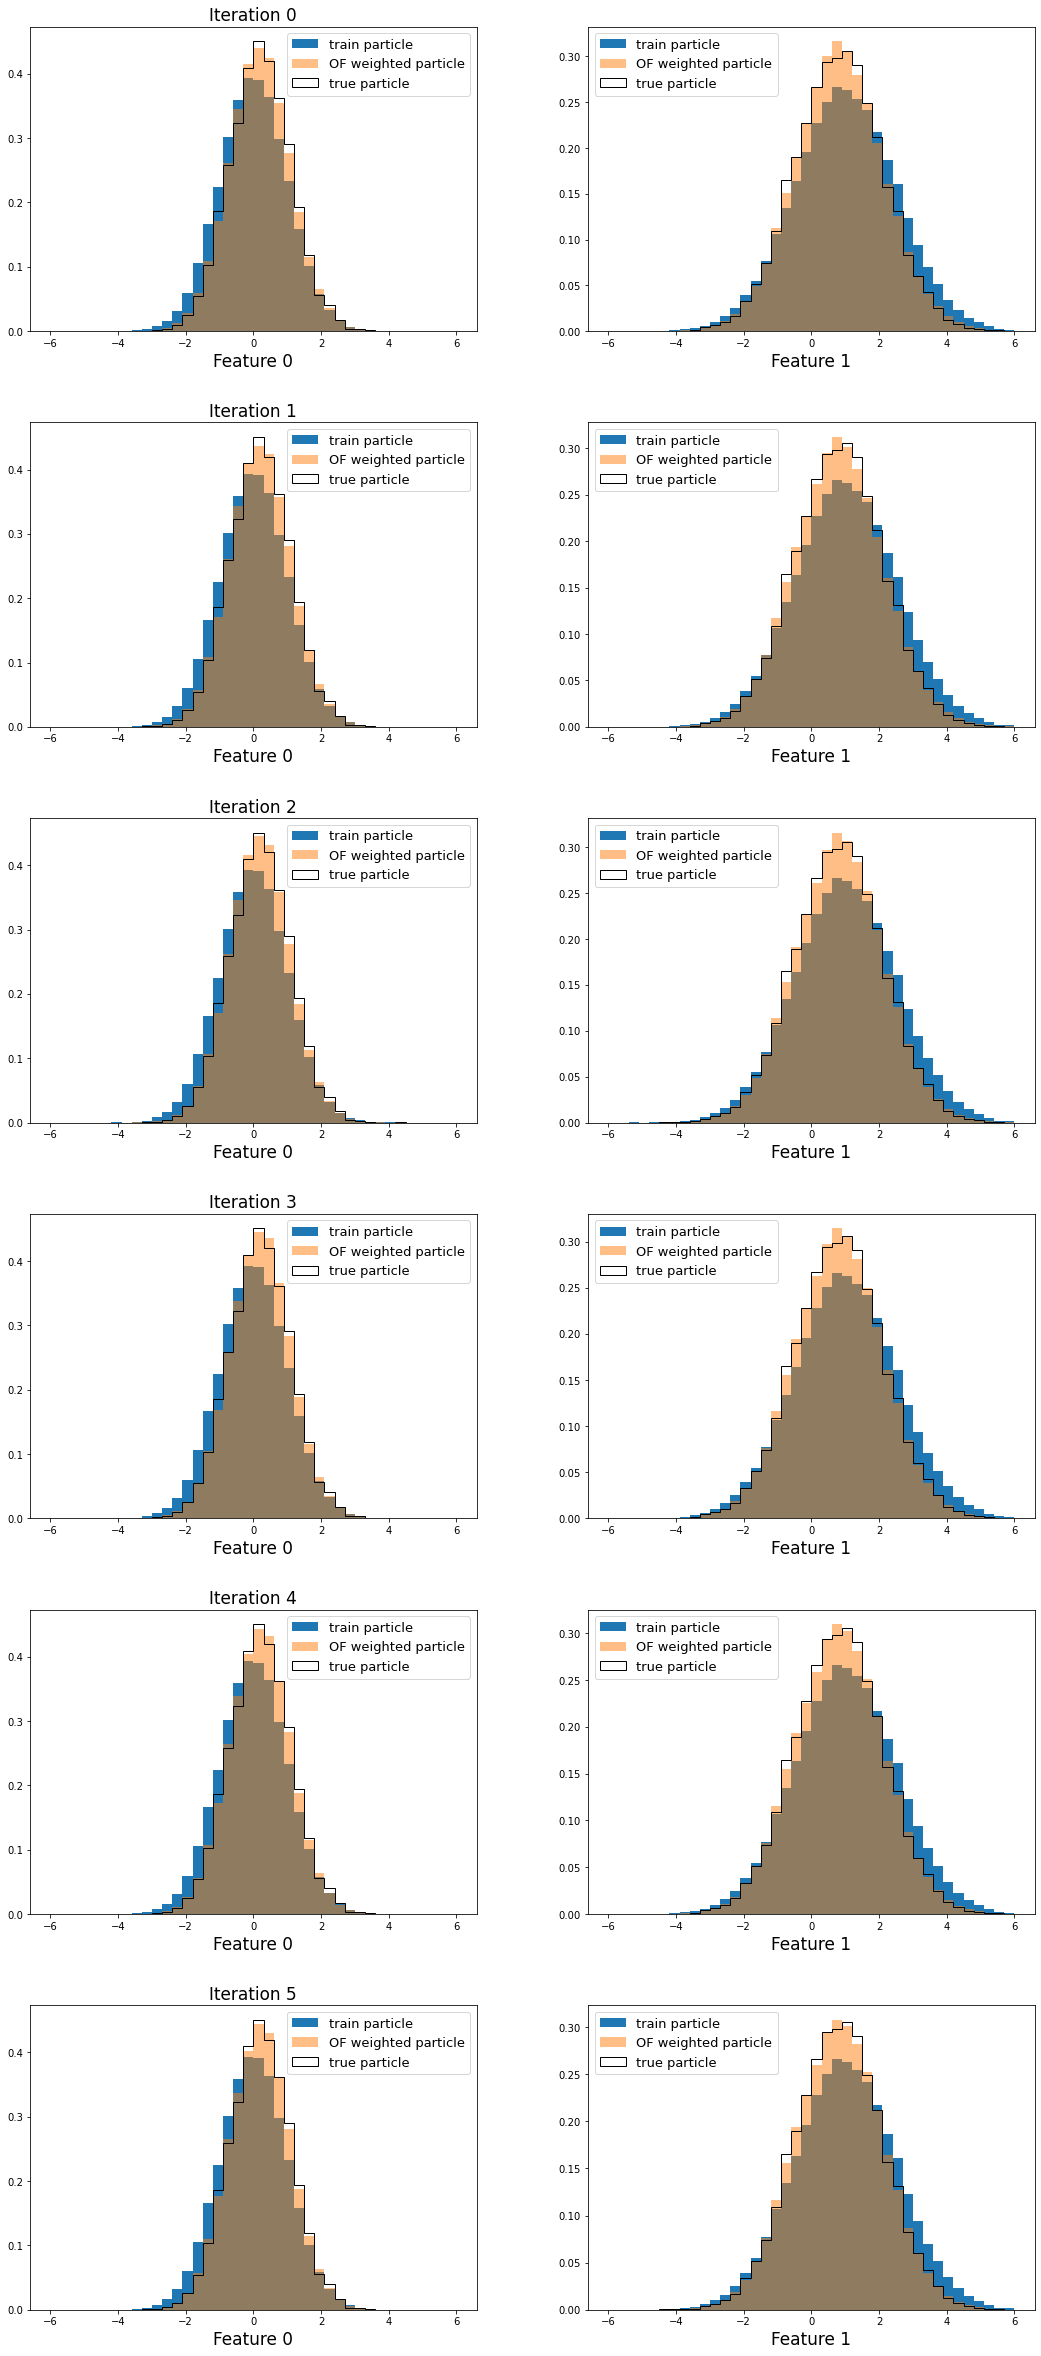

In [19]:

fig,ax = plt.subplots( of_niter, 2, figsize=(18,7*of_niter))

hmin=-6
hmax=6
hbins=40

hist_data_mc_ofweighted = np.zeros( shape=(of_niter,2,hbins))
hist_data_truth         = np.zeros( shape=(of_niter,2,hbins))

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

do_renorm = True


for ofi in range(0,of_niter) :

    if do_renorm :
        ax[ofi][0].hist( train_pts[:,0], bins=hbins, density=True, range=[hmin,hmax], label='train particle' )
        hist_data_mc_ofweighted[ofi,0],_,_ = ax[ofi][0].hist( train_pts[:,0], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
        hist_data_truth[ofi,0],_,_ =         ax[ofi][0].hist( true_pts[:,0], bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

        ax[ofi][1].hist( train_pts[:,1], bins=hbins, density=True, range=[hmin,hmax], label='train particle' )
        hist_data_mc_ofweighted[ofi,1],_,_ = ax[ofi][1].hist( train_pts[:,1], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
        hist_data_truth[ofi,1],_,_ =         ax[ofi][1].hist( true_pts[:,1], bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

    else :

        #ax[ofi][0].hist( train_pts[:,0], bins=hbins, range=[hmin,hmax], label='train particle' )
        hist_data_mc_ofweighted[ofi,0],_,_ = ax[ofi][0].hist( train_pts[:,0], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
        hist_data_truth[ofi,0],_,_ =         ax[ofi][0].hist( true_pts[:,0], bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

        #ax[ofi][1].hist( train_pts[:,1], bins=hbins, range=[hmin,hmax], label='train particle' )
        hist_data_mc_ofweighted[ofi,1],_,_ = ax[ofi][1].hist( train_pts[:,1], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
        hist_data_truth[ofi,1],_,_ =         ax[ofi][1].hist( true_pts[:,1], bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )


    
    ax[ofi][0].legend(loc='best', fontsize=13)
    ax[ofi][1].legend(loc='best', fontsize=13)
    
    
    ax[ofi][0].set_xlabel('Feature 0', fontsize=lfontsize )
    
    ax[ofi][1].set_xlabel('Feature 1', fontsize=lfontsize )
    
    ax[ofi][0].set_title('Iteration %d' % ofi, fontsize=lfontsize )



plt.show

In [20]:
hist_data_diff = hist_data_mc_ofweighted - hist_data_truth
hist_data_diff2 = hist_data_diff * hist_data_diff

hist_data_sum_diff2 = np.zeros( shape=(of_niter,2))

for ofi in range( of_niter ) :
    hist_data_sum_diff2[ofi,0] = np.sum( hist_data_diff2[ofi,0])
    hist_data_sum_diff2[ofi,1] = np.sum( hist_data_diff2[ofi,1])

<function matplotlib.pyplot.show(close=None, block=None)>

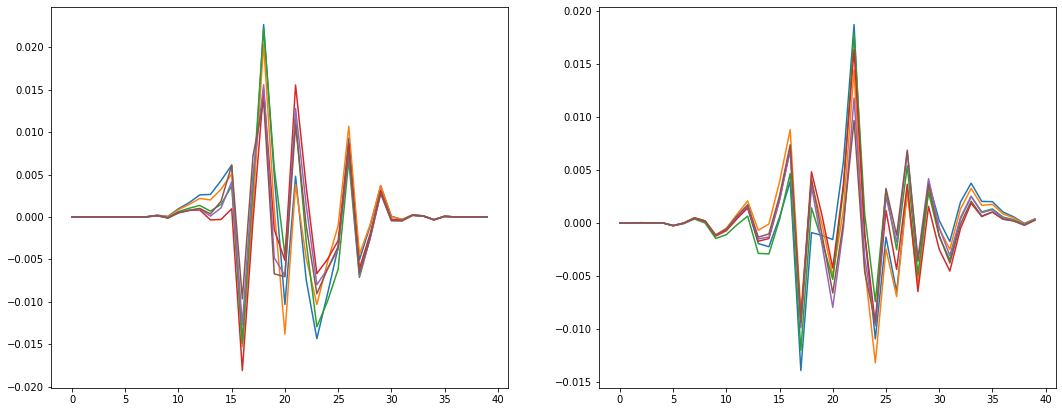

In [21]:
fig,ax = plt.subplots( 1, 2, figsize=(18,7))

for ofi in range(of_niter) :
    ax[0].plot(hist_data_diff[ofi,0])
    ax[1].plot(hist_data_diff[ofi,1])
    
plt.show   

<function matplotlib.pyplot.show(close=None, block=None)>

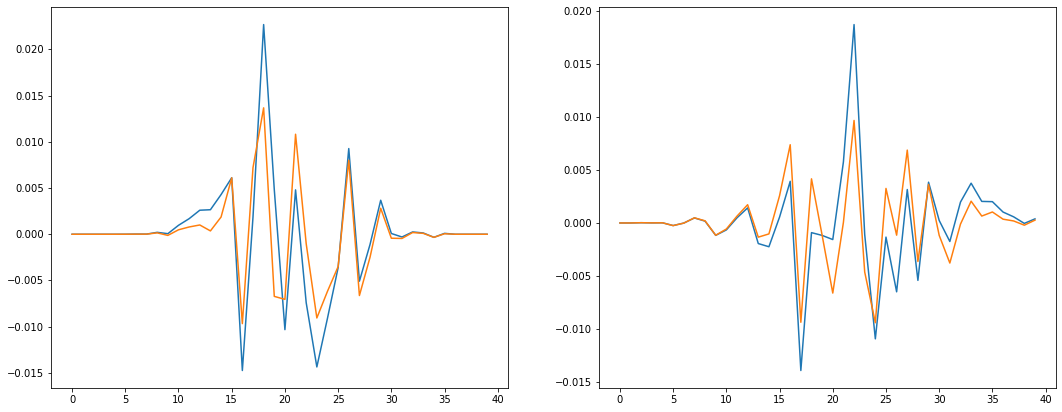

In [22]:
fig,ax = plt.subplots( 1, 2, figsize=(18,7))


ax[0].plot(hist_data_diff[0,0])
ax[1].plot(hist_data_diff[0,1])
    
ofi = of_niter-1
ax[0].plot(hist_data_diff[ofi,0])
ax[1].plot(hist_data_diff[ofi,1])

plt.show  

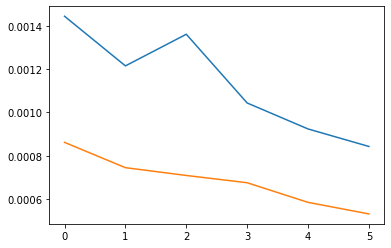

In [23]:
plt.plot( hist_data_sum_diff2)

<function matplotlib.pyplot.show(close=None, block=None)>

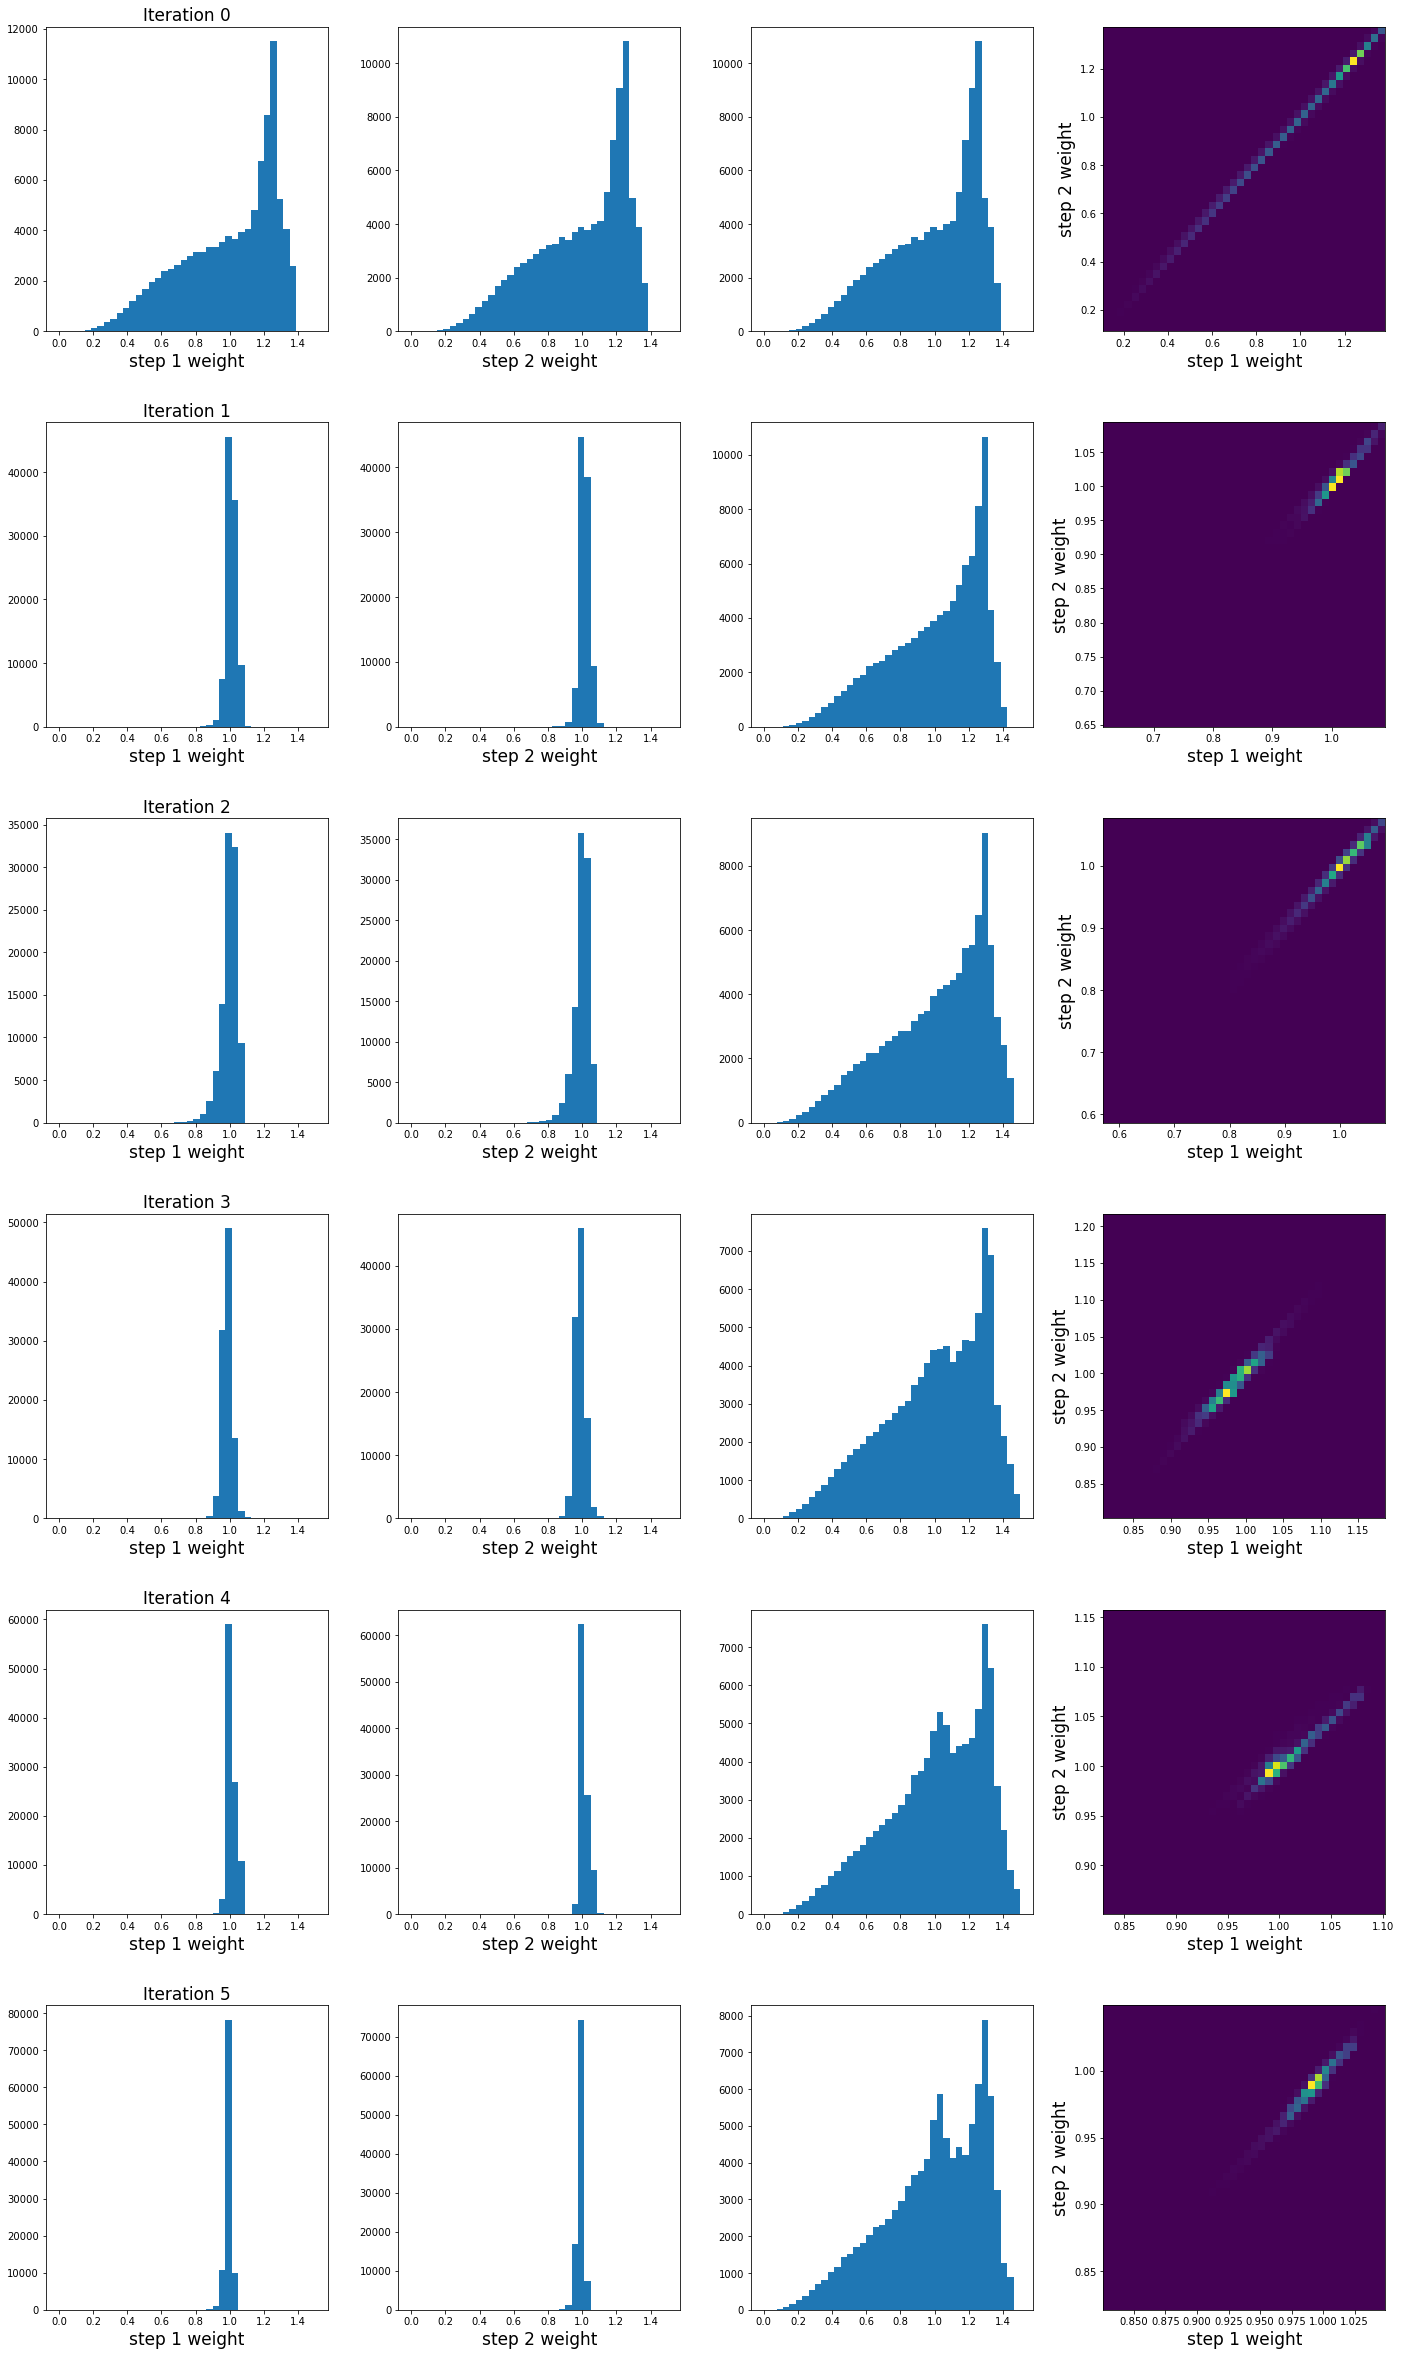

In [24]:
fig,ax = plt.subplots( of_niter, 4, figsize=(24,7*of_niter))

hmin=-6
hmax=6
hbins=40

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

for ofi in range(0,of_niter) :

    ax[ofi][0].hist( of_weights[ofi,0,:], bins=hbins, range=[0.,1.5] )
    ax[ofi][1].hist( of_weights[ofi,1,:], bins=hbins, range=[0.,1.5] )
    ax[ofi][2].hist( push_weights[ofi,:], bins=hbins, range=[0.,1.5] )
    ax[ofi][3].hist2d( of_weights[ofi,0,:], of_weights[ofi,1,:], bins=[hbins,hbins] )
    
    ax[ofi][0].set_xlabel( 'step 1 weight', fontsize=lfontsize )
    
    ax[ofi][1].set_xlabel( 'step 2 weight', fontsize=lfontsize )
    
    ax[ofi][3].set_xlabel( 'step 1 weight', fontsize=lfontsize )
    ax[ofi][3].set_ylabel( 'step 2 weight', fontsize=lfontsize )
    
    ax[ofi][0].set_title('Iteration %d' % ofi, fontsize=lfontsize )
    
    
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

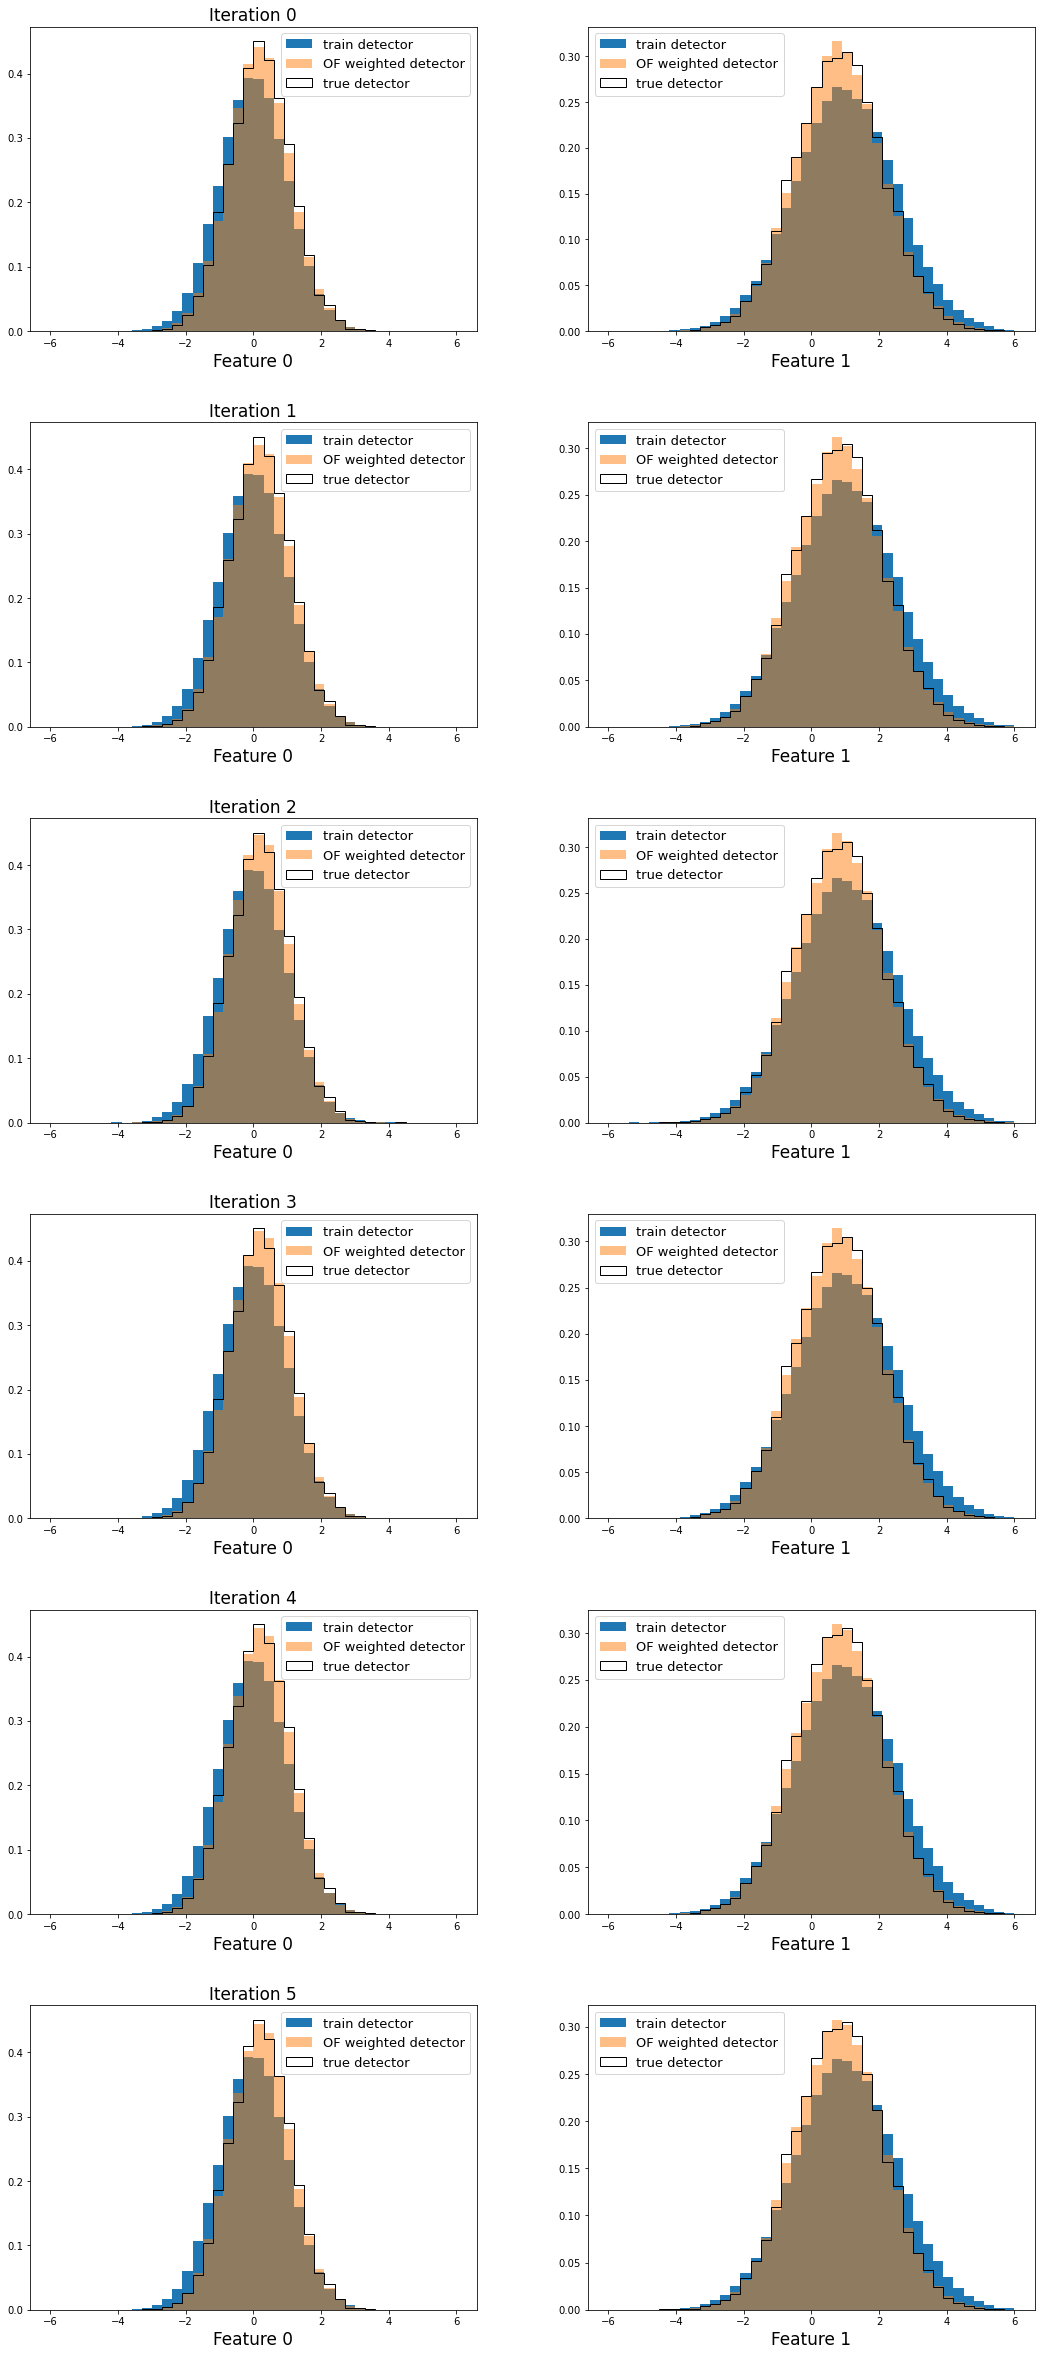

In [25]:

fig,ax = plt.subplots( of_niter, 2, figsize=(18,7*of_niter))

hmin=-6
hmax=6
hbins=40

lfontsize = 17

det_hist_data_mc_ofweighted = np.zeros( shape=(of_niter,2,hbins))
det_hist_data_truth         = np.zeros( shape=(of_niter,2,hbins))

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

do_renorm = True

for ofi in range(0,of_niter) :

    if do_renorm :
        ax[ofi][0].hist( train_det_pts[:,0], bins=hbins, density=True, range=[hmin,hmax], label='train detector' )
        det_hist_data_mc_ofweighted[ofi,0],_,_ =   ax[ofi][0].hist( train_det_pts[:,0], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted detector', alpha=0.5 )
        det_hist_data_truth[ofi,0],_,_         =   ax[ofi][0].hist( true_det_pts[:,0], bins=hbins, density=True, range=[hmin,hmax], label='true detector', histtype='step', color='black' )

        ax[ofi][1].hist( train_det_pts[:,1], bins=hbins, density=True, range=[hmin,hmax], label='train detector' )
        det_hist_data_mc_ofweighted[ofi,1],_,_ =   ax[ofi][1].hist( train_det_pts[:,1], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted detector', alpha=0.5 )
        det_hist_data_truth[ofi,1],_,_         =   ax[ofi][1].hist( true_det_pts[:,1], bins=hbins, density=True, range=[hmin,hmax], label='true detector', histtype='step', color='black' )

    else :

        #ax[ofi][0].hist( train_det_pts[:,0], bins=hbins, range=[hmin,hmax], label='train detector' )
        det_hist_data_mc_ofweighted[ofi,0],_,_ =   ax[ofi][0].hist( train_det_pts[:,0], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted detector', alpha=0.5 )
        det_hist_data_truth[ofi,0],_,_         =   ax[ofi][0].hist( true_det_pts[:,0], bins=hbins, range=[hmin,hmax], label='true detector', histtype='step', color='black' )

        #ax[ofi][1].hist( train_det_pts[:,1], bins=hbins, range=[hmin,hmax], label='train detector' )
        det_hist_data_mc_ofweighted[ofi,1],_,_ =   ax[ofi][1].hist( train_det_pts[:,1], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted detector', alpha=0.5 )
        det_hist_data_truth[ofi,1],_,_         =   ax[ofi][1].hist( true_det_pts[:,1], bins=hbins, range=[hmin,hmax], label='true detector', histtype='step', color='black' )


    
    ax[ofi][0].legend(loc='best', fontsize=13)
    ax[ofi][1].legend(loc='best', fontsize=13)
    
    
    ax[ofi][0].set_xlabel('Feature 0', fontsize=lfontsize )
    
    ax[ofi][1].set_xlabel('Feature 1', fontsize=lfontsize )
    
    ax[ofi][0].set_title('Iteration %d' % ofi, fontsize=lfontsize )



plt.show

In [26]:
det_hist_data_diff = det_hist_data_mc_ofweighted - det_hist_data_truth
det_hist_data_diff2 = det_hist_data_diff * det_hist_data_diff

det_hist_data_sum_diff2 = np.zeros( shape=(of_niter,2))

for ofi in range( of_niter ) :
    det_hist_data_sum_diff2[ofi,0] = np.sum( det_hist_data_diff2[ofi,0])
    det_hist_data_sum_diff2[ofi,1] = np.sum( det_hist_data_diff2[ofi,1])

<function matplotlib.pyplot.show(close=None, block=None)>

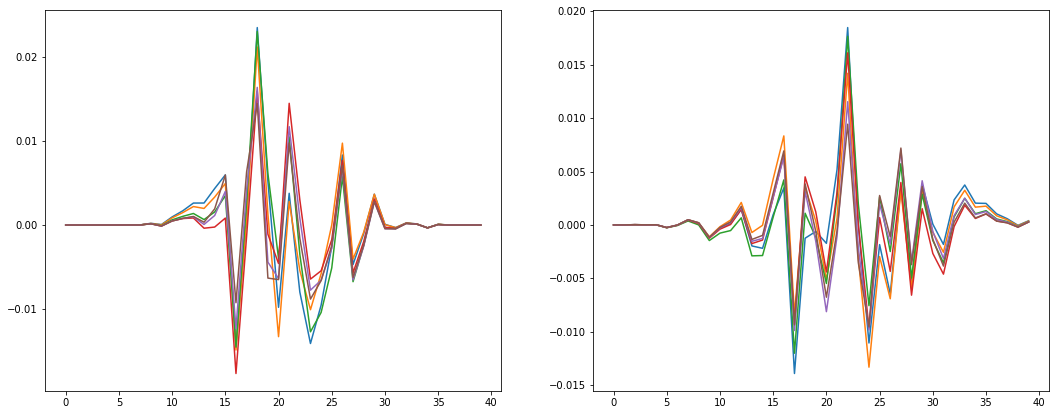

In [27]:
fig,ax = plt.subplots( 1, 2, figsize=(18,7))

for ofi in range(of_niter) :
    ax[0].plot(det_hist_data_diff[ofi,0])
    ax[1].plot(det_hist_data_diff[ofi,1])
    
plt.show  

<function matplotlib.pyplot.show(close=None, block=None)>

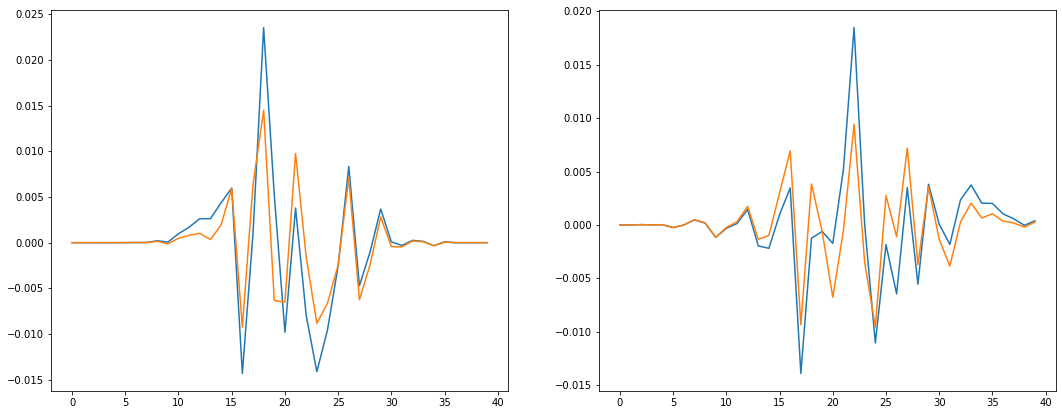

In [28]:
fig,ax = plt.subplots( 1, 2, figsize=(18,7))


ax[0].plot(det_hist_data_diff[0,0])
ax[1].plot(det_hist_data_diff[0,1])
    
ofi = of_niter-1
ax[0].plot(det_hist_data_diff[ofi,0])
ax[1].plot(det_hist_data_diff[ofi,1])

plt.show  

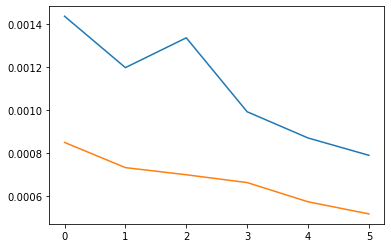

In [29]:
plt.plot( det_hist_data_sum_diff2)

In [30]:
max_step2_weight = np.max( of_weights[of_niter-1,1,:] )
max_push_weight = np.max( final_push_weights )

<function matplotlib.pyplot.show(close=None, block=None)>

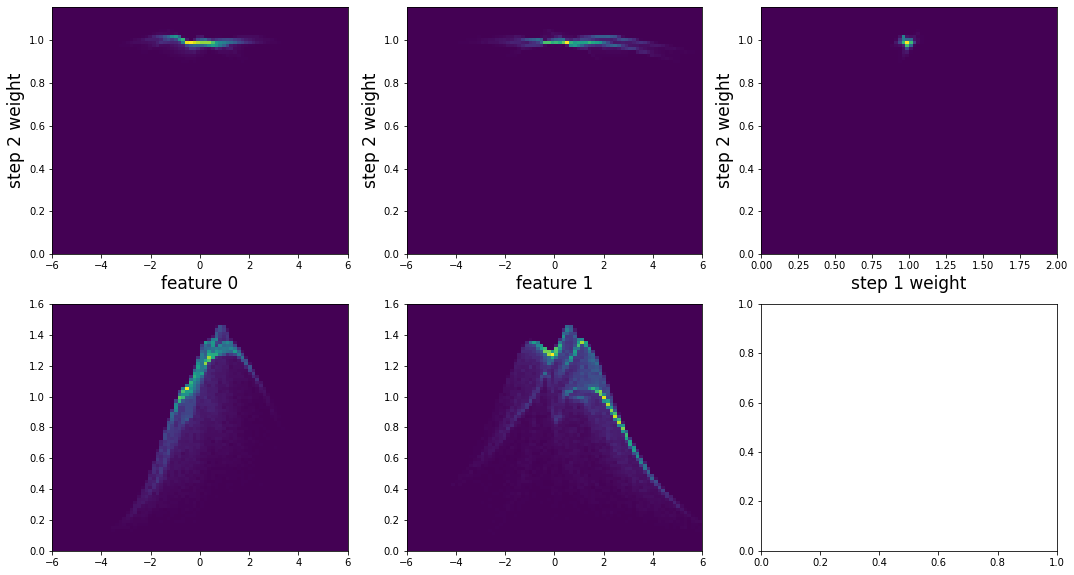

In [31]:
fig,ax = plt.subplots( 2, 3, figsize=(18,10))

hmin=-6
hmax=6
hbins=80

ax[0][0].hist2d( train_pts[:,0], of_weights[of_niter-1,1,:], bins=[hbins,hbins], range=([hmin,hmax],[0.,1.1*max_step2_weight]))

ax[0][1].hist2d( train_pts[:,1], of_weights[of_niter-1,1,:], bins=[hbins,hbins], range=([hmin,hmax],[0.,1.1*max_step2_weight]))

ax[0][2].hist2d( of_weights[3,0,:], of_weights[of_niter-1,1,:], bins=[hbins,hbins], range=([0.,2.],[0.,1.1*max_step2_weight]))


ax[1][0].hist2d( train_pts[:,0], final_push_weights, bins=[hbins,hbins], range=([hmin,hmax],[0.,1.1*max_push_weight]))

ax[1][1].hist2d( train_pts[:,1], final_push_weights, bins=[hbins,hbins], range=([hmin,hmax],[0.,1.1*max_push_weight]))




lfontsize = 17

ax[0][0].set_xlabel( 'feature 0', fontsize=lfontsize )
ax[0][0].set_ylabel( 'step 2 weight', fontsize=lfontsize )


ax[0][1].set_xlabel( 'feature 1', fontsize=lfontsize )
ax[0][1].set_ylabel( 'step 2 weight', fontsize=lfontsize )

ax[0][2].set_xlabel( 'step 1 weight', fontsize=lfontsize )
ax[0][2].set_ylabel( 'step 2 weight', fontsize=lfontsize )


plt.show


In [32]:
step1_mean = np.zeros( of_niter )
step1_rms = np.zeros( of_niter )

step2_mean = np.zeros( of_niter )
step2_rms = np.zeros( of_niter )

iter_val = np.zeros( of_niter )

for ofi in range( of_niter ) :
    
    iter_val[ofi] = ofi
    
    step1_mean[ofi] = np.mean( of_weights[ofi,0,:] )
    step1_rms[ofi] = np.sqrt( np.var( of_weights[ofi,0,:]))
    
    step2_mean[ofi] = np.mean( of_weights[ofi,1,:] )
    step2_rms[ofi] = np.sqrt( np.var( of_weights[ofi,1,:]))
    
    print("  iter %2d : step 1 mean  %.3f  rms %.3f      step 2 mean  %.3f  rms %.3f" % 
          (ofi, step1_mean[ofi], step1_rms[ofi], step2_mean[ofi], step2_rms[ofi]) )

  iter  0 : step 1 mean  0.995  rms 0.275      step 2 mean  0.993  rms 0.269
  iter  1 : step 1 mean  1.010  rms 0.030      step 2 mean  1.012  rms 0.028
  iter  2 : step 1 mean  0.999  rms 0.048      step 2 mean  0.997  rms 0.046
  iter  3 : step 1 mean  0.984  rms 0.028      step 2 mean  0.987  rms 0.030
  iter  4 : step 1 mean  1.011  rms 0.026      step 2 mean  1.011  rms 0.024
  iter  5 : step 1 mean  0.992  rms 0.017      step 2 mean  0.988  rms 0.017


<function matplotlib.pyplot.show(close=None, block=None)>

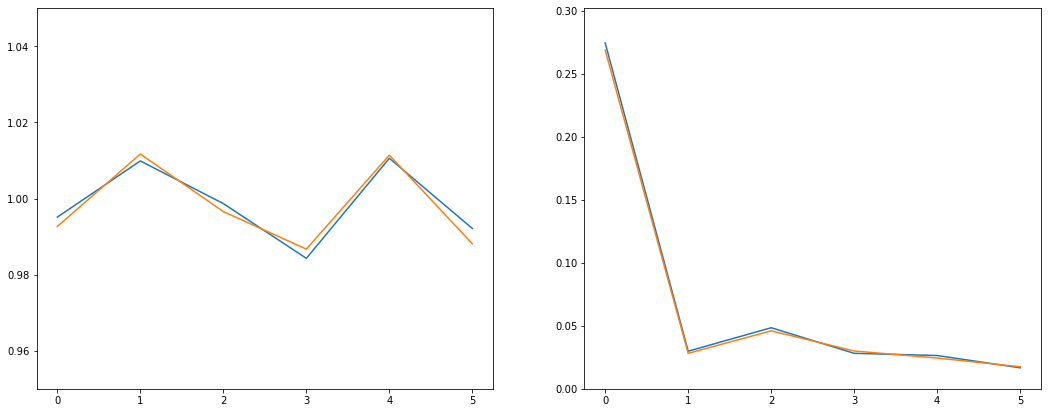

In [33]:
fig,ax = plt.subplots( 1, 2, figsize=(18,7))

ax[0].plot( iter_val, step1_mean )
ax[0].plot( iter_val, step2_mean )
ax[0].set_ylim( 0.95, 1.05)

ax[1].plot( iter_val, step1_rms )
ax[1].plot( iter_val, step2_rms )
ax[1].set_ylim( 0, 1.1*np.max(step1_rms))


plt.show

## Do the bootstrap samples in a loop

In [34]:



verbose = False

bootstrap_weights = np.zeros( shape=(n_boot_samples, len(train_pts) ))

In [35]:
%%time

rng = np.random.default_rng()

for bi in range(0,n_boot_samples) :
    
    if do_bootstrap :
        print("\n Creating bootstrap sample %3d" % bi )
        boot_true_det_pts = rng.choice( true_det_pts, size=len(true_det_pts) )
        
    else :
        print("\n Creating toy sample %3d" % bi )
        boot_true_pts = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true)
        boot_true_det_pts = np.random.normal( boot_true_pts, [res0, res1])
        

        
    boot_of_return_dict = of.omnifold6( 
        train_both, boot_true_det_pts, of_niter, model, verbose, 
        batch_size_setval, learning_rate_setval, epochs_setval )

    boot_of_weights = boot_of_return_dict["weights"]
    
    #print("\n\n bootstrap %d weights:" % bi)
    #print( boot_of_weights )

    mc_weight_sf = (1.*len(boot_true_det_pts))/(1.*len(train_both))

    boot_push_weights = boot_of_return_dict["push_weights"]
    boot_push_weights_scaled = np.copy( boot_push_weights )
    boot_push_weights_scaled = mc_weight_sf * boot_push_weights
    
    #print("\n\n bootstrap %d push weights scaled:" % bi)
    #print( boot_push_weights_scaled )

    boot_final_push_weights = boot_of_return_dict["final_push_weights"]
    boot_final_push_weights_scaled = np.copy(boot_final_push_weights)
    boot_final_push_weights_scaled = mc_weight_sf * boot_final_push_weights
    
    print("\n\n bootstrap %d final push weights scaled:" % bi)
    print( boot_final_push_weights_scaled )

    bootstrap_weights[bi] = np.copy(boot_final_push_weights_scaled)
        
        
 


 Creating bootstrap sample   0
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 681us/step
 weights_push at the beginning
[0.49830726 0.93635982 1.20156157 ... 1.11503887 1.36851716 1.29964936]
10/10 [==============================] - 0s 693us/step
 weights_push at the beginning
[0.53590511 0.91479977 1.22417058 ... 1.10715999 1.41665927 1.34239199]
10/10 [==============================] - 0s 679us/step
 weights_push at the beginning
[0.51475372 0.88566723 1.20259796 ... 1.06203844 1.38746053 1.36033598]
10/10 [==============================] - 0s 727us/step
 weights_push at the beginning
[0.51525948 0.87647488 1.17757618 ... 1.0457951  1.38402645 1.38377867]
10/10 [==============================] - 0s 712us/step
 weights_push at the beginning
[0.52306078 0.89120064 1.17131954 ... 1.07190617 1.37877205 1.40293852]
10/10 [==============================] - 0s 670us/step


 bootstrap 0 final push weights scaled:
[0.04974852 0.08887876 0.1

10/10 [==============================] - 0s 2ms/step
 weights_push at the beginning
[0.53151906 0.92733139 1.17604876 ... 1.07856286 1.35614038 1.27458251]
10/10 [==============================] - 0s 684us/step
 weights_push at the beginning
[0.53828967 0.91823534 1.18591883 ... 1.08126241 1.35858571 1.31288498]
10/10 [==============================] - 0s 647us/step
 weights_push at the beginning
[0.52976448 0.88813905 1.17720392 ... 1.09823254 1.36064288 1.35218807]
10/10 [==============================] - 0s 733us/step
 weights_push at the beginning
[0.53852832 0.90470172 1.15889662 ... 1.11685453 1.33630709 1.32607748]
10/10 [==============================] - 0s 707us/step
 weights_push at the beginning
[0.54549293 0.88624409 1.15822756 ... 1.12356835 1.30775962 1.32018715]
10/10 [==============================] - 0s 706us/step


 bootstrap 6 final push weights scaled:
[0.06557085 0.08473957 0.11567933 ... 0.11333687 0.13037573 0.13426655]

 Creating bootstrap sample   7
 weights_pu

10/10 [==============================] - 0s 697us/step
 weights_push at the beginning
[0.56460851 0.88619459 1.10858393 ... 1.10310328 1.43198001 1.29584098]
10/10 [==============================] - 0s 680us/step
 weights_push at the beginning
[0.6180426  0.86470571 1.14002245 ... 1.10200473 1.41235863 1.28810813]
10/10 [==============================] - 0s 668us/step
 weights_push at the beginning
[0.62438688 0.84236524 1.16772022 ... 1.09214849 1.38845534 1.26656559]
10/10 [==============================] - 0s 713us/step
 weights_push at the beginning
[0.69602323 0.83816828 1.19867718 ... 1.03845547 1.34137095 1.27536296]
10/10 [==============================] - 0s 732us/step
 weights_push at the beginning
[0.6653728  0.82619537 1.24621711 ... 1.07013659 1.38238277 1.27976651]
10/10 [==============================] - 0s 711us/step


 bootstrap 12 final push weights scaled:
[0.07470614 0.08016067 0.12584931 ... 0.10634128 0.13857595 0.12637496]

 Creating bootstrap sample  13
 weights

10/10 [==============================] - 0s 676us/step
 weights_push at the beginning
[0.64149827 0.94316041 1.20129466 ... 1.10235214 1.42094767 1.27197075]
10/10 [==============================] - 0s 691us/step
 weights_push at the beginning
[0.66783985 0.94515127 1.18605975 ... 1.04992627 1.39290919 1.26682622]
10/10 [==============================] - 0s 721us/step
 weights_push at the beginning
[0.6685816  0.94663402 1.15403782 ... 1.07038145 1.37283594 1.24421536]
10/10 [==============================] - 0s 649us/step
 weights_push at the beginning
[0.66993453 0.94155283 1.17151001 ... 1.04314721 1.33469758 1.26212717]
10/10 [==============================] - 0s 704us/step
 weights_push at the beginning
[0.67021636 0.94473354 1.18039542 ... 1.04040915 1.33438604 1.26306001]
10/10 [==============================] - 0s 644us/step


 bootstrap 18 final push weights scaled:
[0.0692712  0.09470657 0.11612278 ... 0.10342132 0.13142738 0.12448107]

 Creating bootstrap sample  19
 weights

10/10 [==============================] - 0s 681us/step
 weights_push at the beginning
[0.63494068 0.90557635 1.13371503 ... 0.97211802 1.19693279 1.38477194]
10/10 [==============================] - 0s 738us/step
 weights_push at the beginning
[0.69783878 0.89387326 1.19639677 ... 1.07326752 1.17161917 1.41139386]
10/10 [==============================] - 0s 769us/step
 weights_push at the beginning
[0.71861312 0.86625668 1.20131336 ... 1.02758748 1.16134304 1.40156327]
10/10 [==============================] - 0s 681us/step
 weights_push at the beginning
[0.65098584 0.92584902 1.29610298 ... 1.06779095 1.13189388 1.41209696]
10/10 [==============================] - 0s 693us/step
 weights_push at the beginning
[0.56854048 0.93083012 1.34321711 ... 1.11332165 1.10485143 1.40951537]
10/10 [==============================] - 0s 680us/step


 bootstrap 24 final push weights scaled:
[0.05660737 0.08897906 0.14020508 ... 0.11646041 0.11259774 0.14482929]

 Creating bootstrap sample  25
 weights

10/10 [==============================] - 0s 687us/step
 weights_push at the beginning
[0.78777277 0.96237195 1.35798323 ... 1.03028309 1.33806145 1.35046017]
10/10 [==============================] - 0s 727us/step
 weights_push at the beginning
[0.8119     0.90402526 1.41221315 ... 0.97986626 1.29142163 1.35039449]
10/10 [==============================] - 0s 706us/step
 weights_push at the beginning
[0.81744303 0.88490169 1.46919236 ... 1.01321878 1.27265589 1.38968864]
10/10 [==============================] - 0s 719us/step
 weights_push at the beginning
[0.83042742 0.90152456 1.56804863 ... 1.00045849 1.28872405 1.43812923]
10/10 [==============================] - 0s 733us/step
 weights_push at the beginning
[0.80484696 0.86915876 1.57950551 ... 0.98543189 1.27767813 1.4348677 ]
10/10 [==============================] - 0s 743us/step


 bootstrap 30 final push weights scaled:
[0.09717329 0.08499795 0.16397848 ... 0.09841292 0.12902287 0.14857854]

 Creating bootstrap sample  31
 weights

10/10 [==============================] - 0s 671us/step
 weights_push at the beginning
[0.52866203 0.93334454 1.21927369 ... 0.94449598 1.30252266 1.29606497]
10/10 [==============================] - 0s 681us/step
 weights_push at the beginning
[0.52490762 0.92528173 1.26627409 ... 0.92243693 1.34603988 1.31459096]
10/10 [==============================] - 0s 672us/step
 weights_push at the beginning
[0.54075483 0.89548057 1.3209687  ... 0.84330328 1.3642714  1.3140181 ]
10/10 [==============================] - 0s 762us/step
 weights_push at the beginning
[0.63131857 0.90406185 1.32292245 ... 0.84205848 1.4060156  1.34711712]
10/10 [==============================] - 0s 681us/step
 weights_push at the beginning
[0.60709506 0.8914503  1.34755119 ... 0.87538001 1.44235213 1.34629161]
10/10 [==============================] - 0s 700us/step


 bootstrap 36 final push weights scaled:
[0.06607312 0.0836828  0.13806094 ... 0.08569527 0.15251555 0.13639629]

 Creating bootstrap sample  37
 weights

10/10 [==============================] - 0s 657us/step
 weights_push at the beginning
[0.6632688  0.87896889 1.22622633 ... 1.06432378 1.34433162 1.3338629 ]
10/10 [==============================] - 0s 712us/step
 weights_push at the beginning
[0.71999228 0.86708895 1.33278335 ... 1.23854177 1.33622792 1.3877219 ]
10/10 [==============================] - 0s 735us/step
 weights_push at the beginning
[0.72158554 0.89777959 1.35799095 ... 1.19423123 1.26818335 1.38892838]
10/10 [==============================] - 0s 692us/step
 weights_push at the beginning
[0.79864526 0.8970979  1.45418958 ... 1.20404634 1.2707729  1.38529198]
10/10 [==============================] - 0s 696us/step
 weights_push at the beginning
[0.8740375  0.89129825 1.44854096 ... 1.10341069 1.177369   1.36915122]
10/10 [==============================] - 0s 699us/step


 bootstrap 42 final push weights scaled:
[0.09475324 0.0893358  0.15671746 ... 0.11109539 0.11931461 0.13929996]

 Creating bootstrap sample  43
 weights

10/10 [==============================] - 0s 658us/step
 weights_push at the beginning
[0.76979405 0.96765053 1.18883753 ... 0.94564623 1.3940717  1.23090506]
10/10 [==============================] - 0s 714us/step
 weights_push at the beginning
[0.99444988 0.92042481 1.24875893 ... 0.90442843 1.41052398 1.28492126]
10/10 [==============================] - 0s 689us/step
 weights_push at the beginning
[1.01360232 0.91188187 1.29628202 ... 0.92424786 1.40018265 1.31071708]
10/10 [==============================] - 0s 637us/step
 weights_push at the beginning
[1.1179616  0.87066504 1.29460128 ... 0.8519279  1.37175756 1.33327391]
10/10 [==============================] - 0s 690us/step
 weights_push at the beginning
[1.07722127 0.86444576 1.31008445 ... 0.8679078  1.33120256 1.3488038 ]
10/10 [==============================] - 0s 661us/step


 bootstrap 48 final push weights scaled:
[0.1149724  0.08527753 0.13636678 ... 0.0837183  0.14240859 0.13427889]

 Creating bootstrap sample  49
 weights

10/10 [==============================] - 0s 710us/step
 weights_push at the beginning
[0.67811513 0.91045642 1.33645296 ... 1.06654513 1.41265833 1.30305648]
10/10 [==============================] - 0s 711us/step
 weights_push at the beginning
[0.71551449 0.88778642 1.41465337 ... 1.0393242  1.40331143 1.33549181]
10/10 [==============================] - 0s 686us/step
 weights_push at the beginning
[0.73388059 0.89660331 1.45025105 ... 1.04405273 1.22405758 1.34640916]
10/10 [==============================] - 0s 645us/step
 weights_push at the beginning
[0.7798756  0.86739244 1.55896531 ... 1.04486285 1.25564701 1.39383631]
10/10 [==============================] - 0s 659us/step
 weights_push at the beginning
[0.73655645 0.87059157 1.56210996 ... 1.07891633 1.07437042 1.3693607 ]
10/10 [==============================] - 0s 687us/step


 bootstrap 54 final push weights scaled:
[0.06404949 0.08335486 0.15812759 ... 0.09793197 0.11102224 0.13891974]

 Creating bootstrap sample  55
 weights

10/10 [==============================] - 0s 721us/step
 weights_push at the beginning
[0.87665009 0.78184319 1.16304207 ... 0.96377355 1.47137392 1.30909359]
10/10 [==============================] - 0s 634us/step
 weights_push at the beginning
[0.87580486 0.77540486 1.19933154 ... 0.99587885 1.45073873 1.32855036]
10/10 [==============================] - 0s 678us/step
 weights_push at the beginning
[0.88359487 0.77522036 1.28730545 ... 1.00273434 1.55224053 1.42374309]
10/10 [==============================] - 0s 627us/step
 weights_push at the beginning
[0.9485605  0.76542366 1.24698424 ... 0.99596046 1.27406923 1.39857353]
10/10 [==============================] - 0s 638us/step
 weights_push at the beginning
[0.93721292 0.73999109 1.26840946 ... 0.93685346 1.25477747 1.4090504 ]
10/10 [==============================] - 0s 719us/step


 bootstrap 60 final push weights scaled:
[0.09676638 0.07654398 0.13323281 ... 0.09538651 0.13565272 0.14665846]

 Creating bootstrap sample  61
 weights

10/10 [==============================] - 0s 760us/step
 weights_push at the beginning
[0.79130584 0.89116496 1.30281746 ... 1.00793326 1.40226519 1.37750673]
10/10 [==============================] - 0s 710us/step
 weights_push at the beginning
[0.82798032 0.87835082 1.36720099 ... 1.00192082 1.36794461 1.38569038]
10/10 [==============================] - 0s 777us/step
 weights_push at the beginning
[0.7168032  0.85875328 1.37922963 ... 0.9395968  1.30235456 1.34931683]
10/10 [==============================] - 0s 713us/step
 weights_push at the beginning
[0.66500053 0.83210566 1.47663667 ... 0.93158314 1.27798578 1.37087731]
10/10 [==============================] - 0s 718us/step
 weights_push at the beginning
[0.73738711 0.79111215 1.46443426 ... 0.83218355 1.21401998 1.36178439]
10/10 [==============================] - 0s 645us/step


 bootstrap 66 final push weights scaled:
[0.07351999 0.08058961 0.14735814 ... 0.08318927 0.1229749  0.13786087]

 Creating bootstrap sample  67
 weights

10/10 [==============================] - 0s 733us/step
 weights_push at the beginning
[0.72020519 0.86095667 1.37943065 ... 0.97418123 1.44540381 1.32522619]
10/10 [==============================] - 0s 682us/step
 weights_push at the beginning
[0.79741498 0.86321472 1.61716359 ... 1.08132702 1.54377633 1.33230192]
10/10 [==============================] - 0s 1ms/step
 weights_push at the beginning
[0.78965197 0.87483774 1.5679071  ... 1.11397549 1.6402837  1.33345005]
10/10 [==============================] - 0s 709us/step
 weights_push at the beginning
[0.75940356 0.86590473 1.62888376 ... 1.13526751 1.82119771 1.33673877]
10/10 [==============================] - 0s 694us/step
 weights_push at the beginning
[0.83133545 0.88820088 1.70917969 ... 1.21802857 1.75962461 1.35079693]
10/10 [==============================] - 0s 685us/step


 bootstrap 72 final push weights scaled:
[0.08431324 0.08602579 0.17729912 ... 0.12992478 0.17634064 0.13368038]

 Creating bootstrap sample  73
 weights_p

10/10 [==============================] - 0s 705us/step
 weights_push at the beginning
[0.57975119 0.92874265 1.40635061 ... 1.06664956 1.38593924 1.42329788]
10/10 [==============================] - 0s 626us/step
 weights_push at the beginning
[0.64776639 0.92785626 1.5029603  ... 1.07944079 1.34006712 1.42963456]
10/10 [==============================] - 0s 687us/step
 weights_push at the beginning
[0.71458513 0.89778248 1.54064589 ... 1.10525104 1.31130984 1.44654761]
10/10 [==============================] - 0s 670us/step
 weights_push at the beginning
[0.75454022 0.91062387 1.52802391 ... 1.0036495  1.26897924 1.48970758]
10/10 [==============================] - 0s 705us/step
 weights_push at the beginning
[0.85614364 0.9111014  1.61361965 ... 1.04087923 1.2570453  1.55678396]
10/10 [==============================] - 0s 752us/step


 bootstrap 78 final push weights scaled:
[0.0907565  0.08920627 0.17717621 ... 0.11072349 0.12683249 0.16311473]

 Creating bootstrap sample  79
 weights

10/10 [==============================] - 0s 744us/step
 weights_push at the beginning
[0.72988009 0.88325226 1.3973794  ... 1.03138936 1.30182576 1.32236767]
10/10 [==============================] - 0s 675us/step
 weights_push at the beginning
[0.70672274 0.85061726 1.44901489 ... 1.04596239 1.32503873 1.38639885]
10/10 [==============================] - 0s 708us/step
 weights_push at the beginning
[0.69485634 0.87272805 1.34067251 ... 1.07629572 1.28199499 1.48318704]
10/10 [==============================] - 0s 693us/step
 weights_push at the beginning
[0.82339346 0.84286805 1.34130461 ... 1.0320389  1.27326849 1.57951649]
10/10 [==============================] - 0s 658us/step
 weights_push at the beginning
[0.87482129 0.83188111 1.28926838 ... 1.05105888 1.24361364 1.67041533]
10/10 [==============================] - 0s 678us/step


 bootstrap 84 final push weights scaled:
[0.08947392 0.08055674 0.13244393 ... 0.10755971 0.11778045 0.17668374]

 Creating bootstrap sample  85
 weights

10/10 [==============================] - 0s 722us/step
 weights_push at the beginning
[0.82255393 0.8840428  1.36648691 ... 1.08802009 1.3758812  1.32902181]
10/10 [==============================] - 0s 725us/step
 weights_push at the beginning
[0.93209708 0.88687084 1.40246422 ... 1.07759885 1.36684923 1.36804767]
10/10 [==============================] - 0s 747us/step
 weights_push at the beginning
[1.05277967 0.88984705 1.4850839  ... 1.09517793 1.33428968 1.40124978]
10/10 [==============================] - 0s 733us/step
 weights_push at the beginning
[1.15792275 0.88855645 1.5891544  ... 1.16485755 1.35870471 1.48798884]
10/10 [==============================] - 0s 654us/step
 weights_push at the beginning
[1.20255932 0.86332399 1.67563181 ... 1.18455386 1.32737359 1.55814611]
10/10 [==============================] - 0s 718us/step


 bootstrap 90 final push weights scaled:
[0.12280233 0.08634607 0.17050299 ... 0.12623636 0.13201852 0.16211993]

 Creating bootstrap sample  91
 weights

10/10 [==============================] - 0s 672us/step
 weights_push at the beginning
[0.75917673 0.93250453 1.50746703 ... 0.94505388 1.38018489 1.43988121]
10/10 [==============================] - 0s 723us/step
 weights_push at the beginning
[0.81907621 0.94807428 1.67011773 ... 0.89145801 1.34985206 1.61972973]
10/10 [==============================] - 0s 742us/step
 weights_push at the beginning
[0.85311462 0.95888321 1.76241113 ... 0.92635848 1.39834699 1.71075684]
10/10 [==============================] - 0s 717us/step
 weights_push at the beginning
[0.87662422 0.95135101 1.69639021 ... 0.92767084 1.37172356 1.69330667]
10/10 [==============================] - 0s 681us/step
 weights_push at the beginning
[0.98435675 0.98385497 1.7768351  ... 0.95369903 1.36787106 1.78581693]
10/10 [==============================] - 0s 676us/step


 bootstrap 96 final push weights scaled:
[0.11240383 0.09612541 0.18006114 ... 0.09921258 0.13029756 0.18103444]

 Creating bootstrap sample  97
 weights

10/10 [==============================] - 0s 685us/step
 weights_push at the beginning
[0.48285004 0.94226021 1.24240851 ... 1.06948245 1.38341773 1.42961752]
10/10 [==============================] - 0s 737us/step
 weights_push at the beginning
[0.50503364 0.93828858 1.37512613 ... 1.09772223 1.33478021 1.65767169]
10/10 [==============================] - 0s 673us/step
 weights_push at the beginning
[0.54252148 0.8811456  1.48148807 ... 1.03751788 1.32268747 1.75433532]
10/10 [==============================] - 0s 664us/step
 weights_push at the beginning
[0.54665063 0.85065836 1.71988457 ... 1.12753335 1.29228544 1.78006873]
10/10 [==============================] - 0s 688us/step
 weights_push at the beginning
[0.60785366 0.88673693 1.79229614 ... 1.1737012  1.26239712 1.75162789]
10/10 [==============================] - 0s 703us/step


 bootstrap 102 final push weights scaled:
[0.06382795 0.08344202 0.17726145 ... 0.11309389 0.124715   0.17477654]

 Creating bootstrap sample 103
 weight

10/10 [==============================] - 0s 686us/step
 weights_push at the beginning
[0.71124732 0.94231611 1.2209723  ... 1.23245466 1.37092805 1.31801891]
10/10 [==============================] - 0s 701us/step
 weights_push at the beginning
[0.77500279 0.91233353 1.25991206 ... 1.19990673 1.3876483  1.35434555]
10/10 [==============================] - 0s 680us/step
 weights_push at the beginning
[0.7819495  0.92390327 1.32945317 ... 1.15014954 1.3592312  1.35886439]
10/10 [==============================] - 0s 690us/step
 weights_push at the beginning
[0.85300461 0.88646582 1.36404102 ... 1.09811857 1.31300635 1.33797142]
10/10 [==============================] - 0s 681us/step
 weights_push at the beginning
[0.91175344 0.89410844 1.39737239 ... 1.12294239 1.31106445 1.3489486 ]
10/10 [==============================] - 0s 703us/step


 bootstrap 108 final push weights scaled:
[0.09156354 0.08734667 0.13742599 ... 0.10852727 0.12800848 0.13330083]

 Creating bootstrap sample 109
 weight

10/10 [==============================] - 0s 671us/step
 weights_push at the beginning
[0.81476068 0.88894624 1.21994901 ... 1.09083116 1.42739654 1.34535801]
10/10 [==============================] - 0s 660us/step
 weights_push at the beginning
[0.89281411 0.88604868 1.2414945  ... 1.00192212 1.47389365 1.33598233]
10/10 [==============================] - 0s 680us/step
 weights_push at the beginning
[0.99575244 0.9020171  1.32499982 ... 1.05078259 1.48200317 1.34725963]
10/10 [==============================] - 0s 735us/step
 weights_push at the beginning
[0.89095763 0.87563147 1.33429436 ... 0.99681225 1.46124206 1.3509139 ]
10/10 [==============================] - 0s 669us/step
 weights_push at the beginning
[0.92134963 0.86349282 1.40590139 ... 1.03011368 1.47796534 1.37664302]
10/10 [==============================] - 0s 706us/step


 bootstrap 114 final push weights scaled:
[0.09687734 0.08909236 0.15022273 ... 0.09625613 0.14815925 0.14411651]

 Creating bootstrap sample 115
 weight

10/10 [==============================] - 0s 685us/step
 weights_push at the beginning
[0.74296272 0.92481726 1.21349812 ... 1.04048443 1.33522272 1.45444787]
10/10 [==============================] - 0s 683us/step
 weights_push at the beginning
[0.73632507 0.92078576 1.18727382 ... 0.96020102 1.21023206 1.51088044]
10/10 [==============================] - 0s 674us/step
 weights_push at the beginning
[0.74495608 0.89611937 1.1851363  ... 0.91054038 1.11255871 1.5427138 ]
10/10 [==============================] - 0s 700us/step
 weights_push at the beginning
[0.73243368 0.88864632 1.15150562 ... 0.94900206 1.05550668 1.53553752]
10/10 [==============================] - 0s 729us/step
 weights_push at the beginning
[0.76730732 0.88557993 1.18426844 ... 0.94937482 1.08631623 1.55272375]
10/10 [==============================] - 0s 684us/step


 bootstrap 120 final push weights scaled:
[0.07267735 0.08611227 0.11912555 ... 0.09940488 0.1077681  0.15966435]

 Creating bootstrap sample 121
 weight

10/10 [==============================] - 0s 719us/step
 weights_push at the beginning
[0.68909544 0.89065903 1.21520877 ... 0.91581887 1.35100269 1.2990036 ]
10/10 [==============================] - 0s 681us/step
 weights_push at the beginning
[0.71221691 0.87473233 1.24348698 ... 0.84210456 1.33077632 1.30115916]
10/10 [==============================] - 0s 657us/step
 weights_push at the beginning
[0.71959361 0.88665319 1.30310347 ... 0.77133621 1.27941887 1.27642163]
10/10 [==============================] - 0s 646us/step
 weights_push at the beginning
[0.70638083 0.91081157 1.36303645 ... 0.77291537 1.30364112 1.2987402 ]
10/10 [==============================] - 0s 646us/step
 weights_push at the beginning
[0.68027968 0.86631191 1.32590558 ... 0.7608136  1.23613432 1.25715604]
10/10 [==============================] - 0s 636us/step


 bootstrap 126 final push weights scaled:
[0.07179008 0.08730451 0.13164407 ... 0.07609977 0.12460496 0.12636482]

 Creating bootstrap sample 127
 weight

10/10 [==============================] - 0s 680us/step
 weights_push at the beginning
[0.68602902 0.885934   1.14118958 ... 1.15711522 1.28232062 1.31477499]
10/10 [==============================] - 0s 716us/step
 weights_push at the beginning
[0.63894543 0.88505805 1.20563844 ... 1.16930336 1.29002362 1.32868241]
10/10 [==============================] - 0s 708us/step
 weights_push at the beginning
[0.64508451 0.91000047 1.13555918 ... 1.13631022 1.26765252 1.32965937]
10/10 [==============================] - 0s 727us/step
 weights_push at the beginning
[0.66285119 0.89931237 1.24755607 ... 1.14648548 1.25912694 1.34316201]
10/10 [==============================] - 0s 687us/step
 weights_push at the beginning
[0.64754161 0.87716643 1.27220676 ... 1.23679432 1.26816279 1.36394045]
10/10 [==============================] - 0s 672us/step


 bootstrap 132 final push weights scaled:
[0.06849752 0.08821163 0.12948863 ... 0.12088781 0.12398906 0.13519307]

 Creating bootstrap sample 133
 weight

10/10 [==============================] - 0s 623us/step
 weights_push at the beginning
[0.72178698 0.90046442 1.26095784 ... 0.98559225 1.27614152 1.25429738]
10/10 [==============================] - 0s 687us/step
 weights_push at the beginning
[0.7881691  0.88650732 1.3047755  ... 1.00553271 1.30341182 1.22804479]
10/10 [==============================] - 0s 675us/step
 weights_push at the beginning
[0.83662464 0.87691095 1.37127052 ... 1.01177968 1.29881269 1.21982131]
10/10 [==============================] - 0s 681us/step
 weights_push at the beginning
[0.85825333 0.89338884 1.46766232 ... 1.01818196 1.33073549 1.21768743]
10/10 [==============================] - 0s 685us/step
 weights_push at the beginning
[0.88938179 0.89518944 1.49791167 ... 1.02764704 1.3096599  1.22287631]
10/10 [==============================] - 0s 652us/step


 bootstrap 138 final push weights scaled:
[0.08590998 0.08929181 0.15423599 ... 0.10285488 0.12683604 0.12402946]

 Creating bootstrap sample 139
 weight

10/10 [==============================] - 0s 727us/step
 weights_push at the beginning
[0.65757298 0.94819742 1.17090166 ... 0.94757754 1.31446433 1.33874488]
10/10 [==============================] - 0s 701us/step
 weights_push at the beginning
[0.70242518 0.94393051 1.24616683 ... 0.98639953 1.28741423 1.37371059]
10/10 [==============================] - 0s 720us/step
 weights_push at the beginning
[0.77572875 0.96886487 1.35167244 ... 0.96406175 1.28223057 1.43697285]
10/10 [==============================] - 0s 705us/step
 weights_push at the beginning
[0.84353259 0.95875137 1.35987083 ... 0.96318177 1.2688233  1.43793042]
10/10 [==============================] - 0s 615us/step
 weights_push at the beginning
[0.85684331 0.93178553 1.27945168 ... 0.93242356 1.20801783 1.39389845]
10/10 [==============================] - 0s 699us/step


 bootstrap 144 final push weights scaled:
[0.08868652 0.09482304 0.12896791 ... 0.09803268 0.11507391 0.14106978]

 Creating bootstrap sample 145
 weight

10/10 [==============================] - 0s 746us/step
 weights_push at the beginning
[0.69570428 0.90466982 1.29384899 ... 1.01592684 1.32068181 1.32994878]
10/10 [==============================] - 0s 717us/step
 weights_push at the beginning
[0.74738793 0.86810965 1.26633047 ... 1.02084261 1.38496923 1.38518585]
10/10 [==============================] - 0s 715us/step
 weights_push at the beginning
[0.81369643 0.88223662 1.31516731 ... 1.05981521 1.39634041 1.41433771]
10/10 [==============================] - 0s 688us/step
 weights_push at the beginning
[0.77700747 0.83352482 1.34334306 ... 1.05151645 1.40183731 1.46205078]
10/10 [==============================] - 0s 730us/step
 weights_push at the beginning
[0.90817105 0.81622924 1.35338601 ... 1.08280432 1.38089591 1.49339458]
10/10 [==============================] - 0s 748us/step


 bootstrap 150 final push weights scaled:
[0.08880071 0.07938535 0.13074871 ... 0.11063127 0.13668294 0.15652429]

 Creating bootstrap sample 151
 weight

10/10 [==============================] - 0s 737us/step
 weights_push at the beginning
[0.57927382 0.89176363 1.16471124 ... 0.9341675  1.39363825 1.38389766]
10/10 [==============================] - 0s 638us/step
 weights_push at the beginning
[0.64530107 0.83879843 1.1520421  ... 1.01239836 1.50272358 1.42490231]
10/10 [==============================] - 0s 715us/step
 weights_push at the beginning
[0.71668021 0.84741909 1.099125   ... 1.06743659 1.48086741 1.39873505]
10/10 [==============================] - 0s 711us/step
 weights_push at the beginning
[0.6864459  0.82787112 1.05132734 ... 1.06101017 1.53536496 1.42759462]
10/10 [==============================] - 0s 636us/step
 weights_push at the beginning
[0.70303683 0.82643192 0.98945485 ... 1.03351672 1.57122598 1.45940123]
10/10 [==============================] - 0s 716us/step


 bootstrap 156 final push weights scaled:
[0.07524157 0.08307084 0.10185336 ... 0.10443156 0.15627348 0.14476733]

 Creating bootstrap sample 157
 weight

10/10 [==============================] - 0s 639us/step
 weights_push at the beginning
[0.54702896 0.881953   1.13229871 ... 0.87740004 1.30685878 1.30729783]
10/10 [==============================] - 0s 705us/step
 weights_push at the beginning
[0.47986486 0.85243416 1.09118472 ... 0.92571808 1.33055642 1.35234818]
10/10 [==============================] - 0s 730us/step
 weights_push at the beginning
[0.48169992 0.85040627 1.09808868 ... 0.85822214 1.35796821 1.40550799]
10/10 [==============================] - 0s 677us/step
 weights_push at the beginning
[0.50104192 0.84246034 1.05335181 ... 0.81852329 1.36132694 1.42371342]
10/10 [==============================] - 0s 691us/step
 weights_push at the beginning
[0.57380581 0.85751607 1.06874297 ... 0.81609264 1.38812454 1.48298181]
10/10 [==============================] - 0s 679us/step


 bootstrap 162 final push weights scaled:
[0.06018198 0.08552775 0.10713628 ... 0.07605152 0.13582072 0.147847  ]

 Creating bootstrap sample 163
 weight

10/10 [==============================] - 0s 689us/step
 weights_push at the beginning
[0.51754171 0.91808265 1.22164345 ... 1.0663327  1.35875666 1.4004277 ]
10/10 [==============================] - 0s 712us/step
 weights_push at the beginning
[0.49512593 0.91952775 1.22558001 ... 0.98310306 1.42169211 1.46041685]
10/10 [==============================] - 0s 745us/step
 weights_push at the beginning
[0.48394205 0.8993406  1.27432162 ... 0.92138359 1.43523331 1.50162328]
10/10 [==============================] - 0s 680us/step
 weights_push at the beginning
[0.51483745 0.9084678  1.34003968 ... 0.91413344 1.495184   1.57500703]
10/10 [==============================] - 0s 740us/step
 weights_push at the beginning
[0.45873252 0.88525817 1.34675617 ... 0.8387715  1.49766831 1.62615744]
10/10 [==============================] - 0s 674us/step


 bootstrap 168 final push weights scaled:
[0.04745155 0.08697197 0.1366196  ... 0.08509037 0.15026188 0.16247445]

 Creating bootstrap sample 169
 weight

10/10 [==============================] - 0s 666us/step
 weights_push at the beginning
[0.67594171 0.94902289 1.22029161 ... 1.08406591 1.28462803 1.31361341]
10/10 [==============================] - 0s 715us/step
 weights_push at the beginning
[0.60401151 0.94746245 1.24410143 ... 0.98130894 1.28507474 1.33664352]
10/10 [==============================] - 0s 717us/step
 weights_push at the beginning
[0.57364424 0.93952611 1.20080063 ... 1.01941894 1.33299745 1.37681512]
10/10 [==============================] - 0s 712us/step
 weights_push at the beginning
[0.5627225  0.9536471  1.24264825 ... 1.00806262 1.39917594 1.43635084]
10/10 [==============================] - 0s 686us/step
 weights_push at the beginning
[0.48239995 0.94060867 1.30864841 ... 1.04622611 1.41478443 1.41018608]
10/10 [==============================] - 0s 712us/step


 bootstrap 174 final push weights scaled:
[0.04619973 0.09529931 0.12873436 ... 0.09775556 0.13370695 0.13593016]

 Creating bootstrap sample 175
 weight

10/10 [==============================] - 0s 675us/step
 weights_push at the beginning
[0.6958096  0.93005991 1.19781899 ... 0.81389034 1.33487523 1.37785113]
10/10 [==============================] - 0s 714us/step
 weights_push at the beginning
[0.68867803 0.93337509 1.18550747 ... 0.87880707 1.26286378 1.36341184]
10/10 [==============================] - 0s 685us/step
 weights_push at the beginning
[0.72785652 0.95333527 1.24366025 ... 0.87280573 1.27580374 1.39383836]
10/10 [==============================] - 0s 698us/step
 weights_push at the beginning
[0.72839864 0.9300227  1.25336508 ... 0.92554006 1.2748979  1.41830836]
10/10 [==============================] - 0s 681us/step
 weights_push at the beginning
[0.73436208 0.95519258 1.32970738 ... 0.97283506 1.24908332 1.45724239]
10/10 [==============================] - 0s 613us/step


 bootstrap 180 final push weights scaled:
[0.08015216 0.09598845 0.13689734 ... 0.10024636 0.1202764  0.14608093]

 Creating bootstrap sample 181
 weight

10/10 [==============================] - 0s 692us/step
 weights_push at the beginning
[0.48870513 0.92164487 1.08263505 ... 0.9554432  1.41674507 1.27817929]
10/10 [==============================] - 0s 767us/step
 weights_push at the beginning
[0.46851703 0.9165051  1.12537138 ... 0.89585762 1.39370149 1.33102454]
10/10 [==============================] - 0s 688us/step
 weights_push at the beginning
[0.52396168 0.9282559  1.24751644 ... 0.85892128 1.33450362 1.45513724]
10/10 [==============================] - 0s 687us/step
 weights_push at the beginning
[0.56888814 0.91361198 1.36924695 ... 0.90640529 1.26084891 1.47641699]
10/10 [==============================] - 0s 726us/step
 weights_push at the beginning
[0.56064912 0.91401114 1.46489567 ... 0.88124929 1.19869175 1.56524762]
10/10 [==============================] - 0s 672us/step


 bootstrap 186 final push weights scaled:
[0.05176674 0.08901379 0.16445042 ... 0.08881354 0.12147958 0.16754825]

 Creating bootstrap sample 187
 weight

10/10 [==============================] - 0s 676us/step
 weights_push at the beginning
[0.47985682 0.87119651 1.25379109 ... 1.04039729 1.31155539 1.35663354]
10/10 [==============================] - 0s 683us/step
 weights_push at the beginning
[0.49416196 0.88786083 1.26719304 ... 0.97671776 1.27931329 1.39878058]
10/10 [==============================] - 0s 726us/step
 weights_push at the beginning
[0.52886642 0.88068283 1.33866114 ... 0.95321279 1.28105491 1.47886164]
10/10 [==============================] - 0s 656us/step
 weights_push at the beginning
[0.56556103 0.9049724  1.46564122 ... 0.88737122 1.32497016 1.5254632 ]
10/10 [==============================] - 0s 697us/step
 weights_push at the beginning
[0.56369295 0.91187906 1.4286237  ... 0.85509718 1.26349366 1.52293613]
10/10 [==============================] - 0s 678us/step


 bootstrap 192 final push weights scaled:
[0.06048902 0.09397004 0.15005746 ... 0.08221011 0.12481101 0.15424148]

 Creating bootstrap sample 193
 weight

10/10 [==============================] - 0s 646us/step
 weights_push at the beginning
[0.52939731 0.90505618 1.22471285 ... 1.04521453 1.47560191 1.22550499]
10/10 [==============================] - 0s 684us/step
 weights_push at the beginning
[0.54969325 0.942727   1.3121428  ... 1.01972538 1.45452976 1.29215723]
10/10 [==============================] - 0s 694us/step
 weights_push at the beginning
[0.52817243 0.94379295 1.27112544 ... 0.96286875 1.37210536 1.35677705]
10/10 [==============================] - 0s 669us/step
 weights_push at the beginning
[0.51693963 0.92212779 1.32669647 ... 0.95940483 1.20654114 1.44039814]
10/10 [==============================] - 0s 695us/step
 weights_push at the beginning
[0.56619102 0.94402025 1.3896026  ... 0.86790777 1.13777098 1.48453504]
10/10 [==============================] - 0s 649us/step


 bootstrap 198 final push weights scaled:
[0.05513262 0.09283492 0.14982819 ... 0.08146639 0.11243662 0.15260019]

 Creating bootstrap sample 199
 weight

10/10 [==============================] - 0s 686us/step
 weights_push at the beginning
[0.49888712 0.95878744 1.29382229 ... 1.03737664 1.38704932 1.38777804]
10/10 [==============================] - 0s 668us/step
 weights_push at the beginning
[0.49143775 0.89742429 1.40771405 ... 0.97848382 1.42783153 1.43468925]
10/10 [==============================] - 0s 813us/step
 weights_push at the beginning
[0.49116651 0.8935949  1.53582587 ... 0.98925639 1.40537622 1.45049705]
10/10 [==============================] - 0s 703us/step
 weights_push at the beginning
[0.50061305 0.89226099 1.59002883 ... 0.97480755 1.40534874 1.42948997]
10/10 [==============================] - 0s 755us/step
 weights_push at the beginning
[0.50401569 0.8926104  1.59566423 ... 0.96129179 1.38609621 1.42533874]
10/10 [==============================] - 0s 617us/step


 bootstrap 204 final push weights scaled:
[0.04754131 0.08961436 0.16300743 ... 0.09428851 0.13583727 0.14521827]

 Creating bootstrap sample 205
 weight

10/10 [==============================] - 0s 697us/step
 weights_push at the beginning
[0.48539552 0.90019745 1.10557008 ... 1.14424503 1.41623652 1.29976034]
10/10 [==============================] - 0s 710us/step
 weights_push at the beginning
[0.49060394 0.90240281 1.07623229 ... 1.05099213 1.46559203 1.27778672]
10/10 [==============================] - 0s 719us/step
 weights_push at the beginning
[0.49818576 0.89862774 1.14407786 ... 1.05262689 1.52010957 1.27943441]
10/10 [==============================] - 0s 721us/step
 weights_push at the beginning
[0.51119342 0.9043691  1.24899848 ... 1.01826898 1.48844636 1.26432276]
10/10 [==============================] - 0s 642us/step
 weights_push at the beginning
[0.53620724 0.91682149 1.28886929 ... 0.98531026 1.39105139 1.25908798]
10/10 [==============================] - 0s 672us/step


 bootstrap 210 final push weights scaled:
[0.05048739 0.09099481 0.13074624 ... 0.09502177 0.13742014 0.12641003]

 Creating bootstrap sample 211
 weight

10/10 [==============================] - 0s 673us/step
 weights_push at the beginning
[0.56074136 0.90929657 1.04415703 ... 1.06601179 1.19583821 1.35798299]
10/10 [==============================] - 0s 636us/step
 weights_push at the beginning
[0.65628034 0.93614262 1.08398497 ... 1.03700542 1.09636104 1.46433443]
10/10 [==============================] - 0s 697us/step
 weights_push at the beginning
[0.64798097 0.93253871 1.10888432 ... 0.94868635 1.03164376 1.46758391]
10/10 [==============================] - 0s 720us/step
 weights_push at the beginning
[0.68419421 0.94727226 1.10712277 ... 0.9459282  1.02422712 1.45816129]
10/10 [==============================] - 0s 700us/step
 weights_push at the beginning
[0.65789277 0.91289627 1.16705524 ... 0.91051671 1.01522335 1.41484272]
10/10 [==============================] - 0s 765us/step


 bootstrap 216 final push weights scaled:
[0.04858679 0.08716384 0.12014998 ... 0.08287228 0.09391208 0.14026565]

 Creating bootstrap sample 217
 weight

10/10 [==============================] - 0s 846us/step
 weights_push at the beginning
[0.47806102 0.88079482 1.12960124 ... 1.13079214 1.33442533 1.28796458]
10/10 [==============================] - 0s 694us/step
 weights_push at the beginning
[0.52760896 0.88719923 1.11308869 ... 1.12958385 1.36840776 1.31786352]
10/10 [==============================] - 0s 668us/step
 weights_push at the beginning
[0.52594608 0.87438305 1.08727229 ... 1.14209173 1.31713379 1.2675508 ]
10/10 [==============================] - 0s 682us/step
 weights_push at the beginning
[0.54517715 0.87029289 1.06903198 ... 1.06912365 1.29676452 1.24106479]
10/10 [==============================] - 0s 687us/step
 weights_push at the beginning
[0.59464364 0.88849955 1.06925475 ... 1.06530927 1.2778828  1.2345675 ]
10/10 [==============================] - 0s 657us/step


 bootstrap 222 final push weights scaled:
[0.05990739 0.08829945 0.10184866 ... 0.10634993 0.12265129 0.11816496]

 Creating bootstrap sample 223
 weight

10/10 [==============================] - 0s 690us/step
 weights_push at the beginning
[0.52187824 0.97369361 1.27187693 ... 1.05395222 1.39833999 1.39840209]
10/10 [==============================] - 0s 784us/step
 weights_push at the beginning
[0.61956679 0.96353017 1.36116144 ... 1.03471383 1.36604014 1.49705981]
10/10 [==============================] - 0s 749us/step
 weights_push at the beginning
[0.68265381 0.97052973 1.33385094 ... 0.97319827 1.41742366 1.50092533]
10/10 [==============================] - 0s 650us/step
 weights_push at the beginning
[0.73112222 0.98403691 1.38718918 ... 0.99650496 1.40205617 1.53606462]
10/10 [==============================] - 0s 630us/step
 weights_push at the beginning
[0.76298169 0.9744985  1.35284071 ... 1.00248985 1.35622523 1.50590497]
10/10 [==============================] - 0s 733us/step


 bootstrap 228 final push weights scaled:
[0.07883606 0.09804833 0.11626054 ... 0.09966894 0.13005417 0.14494681]

 Creating bootstrap sample 229
 weight

10/10 [==============================] - 0s 726us/step
 weights_push at the beginning
[0.501607   0.9766137  1.09098589 ... 0.99313217 1.29581642 1.26107752]
10/10 [==============================] - 0s 722us/step
 weights_push at the beginning
[0.47041484 0.97361556 1.09112193 ... 0.99002199 1.30420911 1.28881922]
10/10 [==============================] - 0s 700us/step
 weights_push at the beginning
[0.45245146 0.97728759 1.09066577 ... 1.00693541 1.30995123 1.31948315]
10/10 [==============================] - 0s 694us/step
 weights_push at the beginning
[0.43925627 0.97439479 1.045002   ... 0.96809133 1.28767516 1.35561058]
10/10 [==============================] - 0s 670us/step
 weights_push at the beginning
[0.4769416  0.96163891 1.08502387 ... 0.93677288 1.29662775 1.36873892]
10/10 [==============================] - 0s 662us/step


 bootstrap 234 final push weights scaled:
[0.04542348 0.09357161 0.11007562 ... 0.09608677 0.12830255 0.1353195 ]

 Creating bootstrap sample 235
 weight

10/10 [==============================] - 0s 702us/step
 weights_push at the beginning
[0.49370328 0.95972252 1.30146825 ... 1.02589393 1.29754603 1.28163505]
10/10 [==============================] - 0s 698us/step
 weights_push at the beginning
[0.51973558 0.94367865 1.31953653 ... 1.03869943 1.36201213 1.31968255]
10/10 [==============================] - 0s 702us/step
 weights_push at the beginning
[0.54673875 0.94359    1.27806105 ... 1.05182487 1.32454514 1.30422743]
10/10 [==============================] - 0s 715us/step
 weights_push at the beginning
[0.56875375 0.95000264 1.32021801 ... 1.03050044 1.33188725 1.29412778]
10/10 [==============================] - 0s 762us/step
 weights_push at the beginning
[0.56688638 0.95500146 1.37988808 ... 0.9876758  1.42459849 1.30738376]
10/10 [==============================] - 0s 616us/step


 bootstrap 240 final push weights scaled:
[0.05700148 0.09480061 0.14097276 ... 0.09531543 0.14634727 0.13119479]

 Creating bootstrap sample 241
 weight

10/10 [==============================] - 0s 701us/step
 weights_push at the beginning
[0.4457165  0.95140064 1.13486731 ... 1.08241057 1.25731802 1.30567777]
10/10 [==============================] - 0s 669us/step
 weights_push at the beginning
[0.41882869 0.93051506 1.13141243 ... 1.05466046 1.29506615 1.27905465]
10/10 [==============================] - 0s 678us/step
 weights_push at the beginning
[0.41926731 0.92871956 1.14578941 ... 1.02463876 1.27443838 1.25482153]
10/10 [==============================] - 0s 720us/step
 weights_push at the beginning
[0.44093089 0.92308066 1.22699074 ... 1.02431635 1.323094   1.23835499]
10/10 [==============================] - 0s 688us/step
 weights_push at the beginning
[0.46683443 0.91441074 1.26801282 ... 1.04954021 1.32124609 1.1989329 ]
10/10 [==============================] - 0s 717us/step


 bootstrap 246 final push weights scaled:
[0.05292437 0.09314644 0.13444512 ... 0.10513875 0.1365102  0.12096466]

 Creating bootstrap sample 247
 weight

In [36]:
bootstrap_weights

array([[0.04974852, 0.08887876, 0.11439495, ..., 0.1061682 , 0.13592404,
        0.13967174],
       [0.06441592, 0.08237587, 0.11767702, ..., 0.10114538, 0.14464276,
        0.13007995],
       [0.05763307, 0.0841043 , 0.1341072 , ..., 0.10557889, 0.13879795,
        0.12961012],
       ...,
       [0.05745588, 0.08898883, 0.18515176, ..., 0.10304028, 0.14680065,
        0.12408331],
       [0.03133315, 0.09331464, 0.12322748, ..., 0.10535774, 0.14005506,
        0.1425821 ],
       [0.0737571 , 0.09634742, 0.13838624, ..., 0.10531869, 0.1178079 ,
        0.13019925]])

In [37]:
bootstrap_weights[0]

array([0.04974852, 0.08887876, 0.11439495, ..., 0.1061682 , 0.13592404,
       0.13967174])

In [38]:
np.cov( bootstrap_weights[:,0])

array(0.00030954)

In [39]:
bootstrap_weights[:,100]

array([0.09219782, 0.09775535, 0.09157385, 0.08973098, 0.09131237,
       0.09764188, 0.0941865 , 0.10533036, 0.09060847, 0.08657904,
       0.09260141, 0.10029886, 0.08474551, 0.08624889, 0.08632872,
       0.0915719 , 0.09009666, 0.09574615, 0.09584755, 0.09163246,
       0.09758072, 0.09515682, 0.0975359 , 0.08891656, 0.08898225,
       0.09621029, 0.09728186, 0.09150753, 0.08718017, 0.08285139,
       0.08609954, 0.07961895, 0.08405513, 0.08646474, 0.08677862,
       0.08518729, 0.08644414, 0.08422331, 0.09395246, 0.09319947,
       0.10118183, 0.09017666, 0.08562853, 0.09286982, 0.09022518,
       0.09041414, 0.09119795, 0.09085245, 0.08964793, 0.10427659,
       0.09177851, 0.09338343, 0.09517702, 0.09524987, 0.08998614,
       0.09863156, 0.09031663, 0.0942818 , 0.09430128, 0.09338797,
       0.09332522, 0.09566725, 0.10167576, 0.10191556, 0.09940711,
       0.09095689, 0.08747988, 0.09344529, 0.0953717 , 0.09869342,
       0.09382477, 0.0834035 , 0.08888527, 0.09678054, 0.09610

<function matplotlib.pyplot.show(close=None, block=None)>

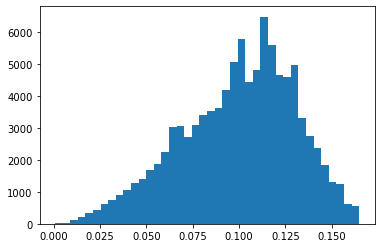

In [40]:
plt.hist( bootstrap_weights[1,:], bins=40)
plt.show

In [41]:
np.mean( bootstrap_weights, axis=0 )

array([0.07180497, 0.08798288, 0.14129811, ..., 0.09895649, 0.13235455,
       0.14137755])

In [42]:
bootstrap_w2 = bootstrap_weights * bootstrap_weights

In [43]:
bootstrap_w2

array([[0.00247492, 0.00789943, 0.0130862 , ..., 0.01127169, 0.01847535,
        0.0195082 ],
       [0.00414941, 0.00678578, 0.01384788, ..., 0.01023039, 0.02092153,
        0.01692079],
       [0.00332157, 0.00707353, 0.01798474, ..., 0.0111469 , 0.01926487,
        0.01679878],
       ...,
       [0.00330118, 0.00791901, 0.03428118, ..., 0.0106173 , 0.02155043,
        0.01539667],
       [0.00098177, 0.00870762, 0.01518501, ..., 0.01110025, 0.01961542,
        0.02032966],
       [0.00544011, 0.00928283, 0.01915075, ..., 0.01109203, 0.0138787 ,
        0.01695184]])

In [44]:
bootstrap_variance = np.mean( bootstrap_w2, axis=0 ) - np.mean( bootstrap_weights, axis=0 ) * np.mean( bootstrap_weights, axis=0 )

In [45]:
bootstrap_variance

array([3.08299449e-04, 2.98462249e-05, 4.33430715e-04, ...,
       1.53954111e-04, 2.21059803e-04, 2.92646926e-04])

In [46]:
bootstrap_rms = np.sqrt( bootstrap_variance )

In [47]:
bootstrap_rms

array([0.01755846, 0.00546317, 0.020819  , ..., 0.01240782, 0.01486808,
       0.01710693])

In [48]:
bootstrap_weights.shape

(250, 100000)

In [49]:
bootstrap_weights.T.shape

(100000, 250)

In [50]:
bootstrap_weights_dot = np.dot( bootstrap_weights, bootstrap_weights.T )

In [51]:
bootstrap_weights_dot

array([[1097.7023936 , 1091.00661875, 1078.80367747, ..., 1090.10608785,
        1091.109636  , 1100.92977298],
       [1091.00661875, 1089.45645658, 1074.73719152, ..., 1084.39579157,
        1087.08609354, 1097.19527326],
       [1078.80367747, 1074.73719152, 1068.30610339, ..., 1075.51162453,
        1078.25658339, 1087.49315   ],
       ...,
       [1090.10608785, 1084.39579157, 1075.51162453, ..., 1104.51123728,
        1246.35580137, 1101.30190251],
       [1091.109636  , 1087.08609354, 1078.25658339, ..., 1246.35580137,
        4920.15929757, 1110.5101186 ],
       [1100.92977298, 1097.19527326, 1087.49315   , ..., 1101.30190251,
        1110.5101186 , 1127.10416058]])

In [52]:
bootstrap_weights_dot.shape

(250, 250)

In [53]:
combined_row = np.row_stack( (bootstrap_weights[:,0], bootstrap_weights[:,2]))

In [54]:
pair_cov_rs = np.cov( combined_row )

In [55]:
pair_cov_rs

array([[3.09537599e-04, 3.53964554e-05],
       [3.53964554e-05, 4.35171401e-04]])

In [56]:
pair_cor = np.corrcoef(combined_row)

In [57]:
pair_cor

array([[1.        , 0.09644349],
       [0.09644349, 1.        ]])

In [58]:
pair_cor[0,1]

0.09644348517951873

In [59]:
len(bootstrap_weights[0,:])

100000

In [60]:
ncalc = len(bootstrap_weights[0,:])
corr_array = np.zeros( ncalc )

point_index = 24

for i in range(ncalc) :
    pair_cor = np.corrcoef( np.row_stack( (bootstrap_weights[:,point_index], bootstrap_weights[:,i]) ))
    corr_array[i] = pair_cor[0,1]


In [61]:
corr_array

array([ 0.08612756, -0.20478747, -0.05951744, ...,  0.02171754,
        0.03787166, -0.04688028])

<function matplotlib.pyplot.show(close=None, block=None)>

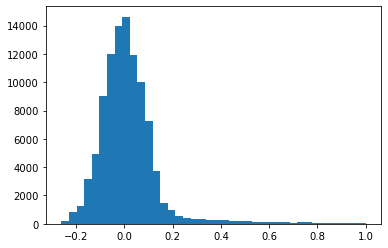

In [62]:
plt.hist( corr_array, bins=40)
plt.show

In [63]:
train_pts[point_index]

array([-1.55595217,  4.01347378])

In [64]:
df0 = train_pts[:,0] - train_pts[point_index,0]
df1 = train_pts[:,1] - train_pts[point_index,1]
dr = np.sqrt( df0*df0 + df1*df1)

<function matplotlib.pyplot.show(close=None, block=None)>

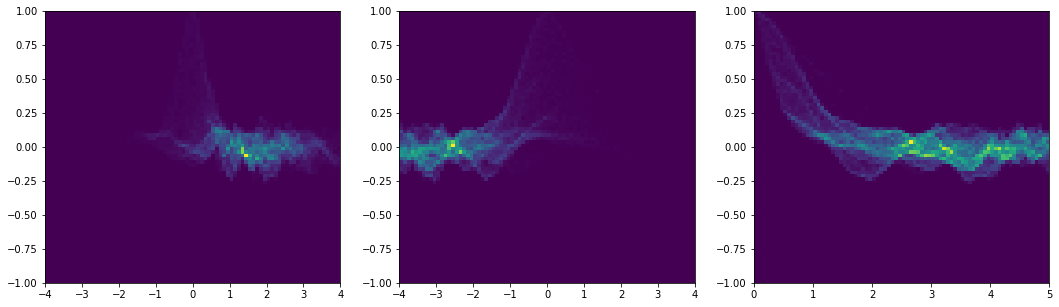

In [65]:
fig,ax = plt.subplots( 1, 3, figsize=(18,5))
ax[0].hist2d( df0, corr_array, bins=[80,80], range=([-4,4],[-1,1]))
ax[1].hist2d( df1, corr_array, bins=[80,80], range=([-4,4],[-1,1]))
ax[2].hist2d( dr, corr_array, bins=[80,80], range=([0,5],[-1,1]))
plt.show

## Save the output

In [66]:
with open( '%s.npy' % output_filebase, 'wb') as f :
    np.save(f, train_pts)
    np.save(f, train_det_pts)
    np.save(f, true_pts)
    np.save(f, true_det_pts)
    np.save(f, bootstrap_weights)
    